<a href="https://colab.research.google.com/github/martostwo/Recurrent_Neural_Network_TimeSeries_Forecasting/blob/main/RNN_Automatization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import & Dark Mode

Modules Installation

In [ ]:
!pip install yfinance
!pip install ta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 KB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.8/112.8 KB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 KB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 KB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 102.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 10.2 MB/s eta 0:00:00
  Attempting uninstall: html5lib
    Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.9.3
    Uninstalling beautifulsoup4-4.9.3:
      Successfully uninstalled beautifulsoup4

Module import & Dark Mode

In [ ]:
#Module Import:
import pandas as pd;
import numpy as np;
import warnings;
import yfinance as yf;
import ta;
import matplotlib.pyplot as plt;
from matplotlib import cycler;
plt.style.use('seaborn');
warnings.filterwarnings("ignore");

#Dark mode for Graphics:
colors = cycler(
    'color',
    [
    '#669FEE','#66EE91', '#9988DD',
    '#EECC55', '#88BB44', '#FFBBBB'
    ]
);

plt.rc('figure', facecolor = '#313233');
plt.rc('axes', facecolor = "#313233", edgecolor='none',
       axisbelow=True, grid=True, prop_cycle=colors,
       labelcolor = 'gray');

plt.rc('grid', color='474A4A', linestyle='solid');
plt.rc('xtick', color='gray');
plt.rc('ytick', direction='out', color='gray');
plt.rc('legend', facecolor="#313233", edgecolor="#313233");
plt.rc("text", color="#C9C9C9");
plt.rc('figure', facecolor='#313233');

<ipython-input-2-e0d92d8f87f3>:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn');


#Preprocessing & Features

Preprocessing & Feature Engineering Functions (Yahoo Finance)

In [ ]:
def yf_preprocessing(ticker):
  df = yf.download(ticker, start="1990-01-01")
  df.columns = ["open", "high", "low", "close", "adj close", "volume"]
  df.index.name = "date"
  return df

def yf_feature(df):

    #Copiamos el DataFrame para evitar interferencias en los datos:
    df_copy = df.copy()

    #creamos el retorno:
    df_copy["returns"] = df_copy["close"].pct_change(1)

    #price
    df_copy["op"] = df_copy["open"].shift(1)
    df_copy["hi"] = df_copy["high"].shift(1)
    df_copy["lo"] = df_copy["low"].shift(1)
    df_copy["clo"] = df_copy["close"].shift(1)

    #Volume
    df_copy["vol"] = df_copy["volume"].shift(1)

    #Creamos las SMAs:
    df_copy["SMA 15"] = df_copy[["close"]].rolling(15).mean().shift(1)
    df_copy["SMA 60"] = df_copy[["close"]].rolling(60).mean().shift(1)

    #Creamos la volatilidad:
    df_copy["MSD 15"] = df_copy["returns"].rolling(15).std().shift(1)
    df_copy["MSD 60"] = df_copy["returns"].rolling(60).std().shift(1)

    #creamos VWAP:
    vwap = ta.volume.VolumeWeightedAveragePrice(
        high=df['high'],
        low=df['low'],
        close=df['close'],
        volume=df['volume'],
        window=5  # periodo de tiempo para el cálculo del VWAP
    )
    df_copy["vwap"] = vwap.vwap.shift(1)

    #Creamos el RSI:
    RSI = ta.momentum.RSIIndicator(df_copy["close"], window = 5, fillna = False)
    df_copy["rsi"] = RSI.rsi().shift(1)

    return df_copy.dropna();

Transform 2D array to 3D

In [ ]:
def X_3d_RNN(X_s, y_s, lag):

    # Verificación simple de longitudes
    if len(X_s) != len(y_s):
        print("Warnings")

    # Creamos la variable X_train
    X_train = []
    for variable in range(0, X_s.shape[1]):
        X = []
        for i in range(lag, X_s.shape[0]):
            X.append(X_s[i-lag:i, variable])
        X_train.append(X)
    X_train, np.array(X_train)
    X_train = np.swapaxes(np.swapaxes(X_train, 0, 1), 1, 2)

    # Creamos la variable y_train
    y_train = []
    for i in range(lag, y_s.shape[0]):
        y_train.append(y_s[i, :].reshape(-1,1).transpose())
    y_train = np.concatenate(y_train, axis=0)
    return X_train, y_train

#Model Automatization

In [ ]:
def RNN(ticker, num_model=None):

  #Feature engineering
  df = yf_preprocessing(ticker);
  df = yf_feature(df);

  #Percentage train set
  split = int(0.85*len(df));
  split_val = int(0.95*len(df));

  #Train set
  x_train = df[['vwap','rsi','SMA 15','SMA 60','MSD 15','MSD 60','op','hi','lo','clo','vol']].iloc[:split,:]
  y_train = df[['returns']].iloc[:split,:]

  #Validation set
  x_val = df[['vwap','rsi','SMA 15','SMA 60','MSD 15','MSD 60','op','hi','lo','clo','vol']].iloc[split:split_val,:]
  y_val = df[['returns']].iloc[split:split_val,:]

  #Test set
  x_test = df[['vwap','rsi','SMA 15','SMA 60','MSD 15','MSD 60','op','hi','lo','clo','vol']].iloc[split_val:,:]
  y_test = df[['returns']].iloc[split_val:,:]

  #Standardization
  from sklearn.preprocessing import StandardScaler
  sc = StandardScaler()

  #Estandarizamos conjunto de entrenamiento
  x_train_sc = sc.fit_transform(x_train)

  #Estandarizamos conjunto de testing
  x_val_sc = sc.transform(x_val)

  #Estandarizamos conjunto de testing
  x_test_sc = sc.transform(x_test)

  lag = 15
  x_train_3d, y_train_3d = X_3d_RNN(x_train_sc, y_train.values, lag)
  x_val_3d, y_val_3d = X_3d_RNN(x_val_sc, y_val.values, lag)
  x_test_3d, y_test_3d = X_3d_RNN(x_test_sc, y_test.values, lag)

  from tensorflow import keras
  from keras import layers

  def build_model(input_shape, LSTM_units = 10, dropout = 0.2, GRU_units = 100, Dense_units = 125):

    #Model:
    inputs = layers.Input(shape = input_shape)
    x = inputs
    x = layers.LSTM(LSTM_units, return_sequences = True)(x)
    x = layers.Dropout(dropout)(x)
    x = layers.GRU(GRU_units, return_sequences = False)(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(Dense_units, activation = "relu")(x)
    outputs = layers.Dense(1)(x)

    return keras.Model(inputs, outputs)

  #We are now ready to build and train the model.
  input_shape = x_train_3d.shape[1:]

  model = build_model(input_shape)

  model.compile(
      loss="mean_squared_error",
      optimizer=keras.optimizers.Adam()
  )

  #model.summary()

  callbacks = [keras.callbacks.EarlyStopping(patience=5, \
      restore_best_weights=True)]

  model.fit(
      x_train_3d,
      y_train_3d,
      validation_data = (x_val_3d, y_val_3d),
      epochs=200,
      batch_size=64,
      callbacks=callbacks,
  )

  # Create predictions for the whole dataset
  y_pred_train = np.concatenate((np.zeros([lag,1]), model.predict(x_train_3d)), axis=0)

  y_pred_val = np.concatenate((np.zeros([lag,1]), model.predict(x_val_3d)), axis=0)

  y_pred_test = np.concatenate((np.zeros([lag,1]), model.predict(x_test_3d)), axis=0)

  df["prediction"] = np.concatenate((y_pred_train, y_pred_val, y_pred_test), axis=0)

  #Calculamos la estrategia:
  df["strategy"] = df["returns"]*np.sign(df["prediction"].shift(1))

  if num_model != None:
    
    model.save(f"/content/drive/MyDrive/Deep Learning aplicado al trading algorítmico/Models/ModelsRNN_{ticker}/RNN_{num_model}.h5")
    return df["strategy"].iloc[split:split_val], df["strategy"].iloc[split_val:]

  else:

    return df["strategy"].iloc[split:split_val], df["strategy"].iloc[split_val:]

In [ ]:
#data_path ="/content/drive/MyDrive/Deep Learning aplicado al trading algorítmico/EURUSD_Daily_1990.csv"

#Library to estimate the time until the end of the loop
from tqdm import tqdm;

#Empty list to contain the returns
returns_val = [];
returns_test = [];

#Compute the returns during the test and validation periods
for i in tqdm(range(100)):
  val, test = RNN("^GSPC", num_model=i)
  returns_val.append(val)
  returns_test.append(test)
  


  0%|          | 0/100 [00:00<?, ?it/s]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 20s 22ms/step - loss: 9.3597e-04 - val_loss: 3.2417e-04
Epoch 2/200
111/111 [==============================] - 1s 9ms/step - loss: 2.9237e-04 - val_loss: 2.1680e-04
Epoch 3/200
111/111 [==============================] - 1s 9ms/step - loss: 2.0157e-04 - val_loss: 2.1226e-04
Epoch 4/200
111/111 [==============================] - 1s 6ms/step - loss: 1.7900e-04 - val_loss: 2.1407e-04
Epoch 5/200
111/111 [==============================] - 1s 6ms/step - loss: 1.6352e-04 - val_loss: 2.0940e-04
Epoch 6/200
111/111 [==============================] - 1s 6ms/step - loss: 1.5328e-04 - val_loss: 2.3830e-04
Epoch 7/200
111/111 [==============================] - 1s 6ms/step - loss: 1.4684e-04 - val_loss: 2.1177e-04
Epoch 8/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4403e-04 - val_loss: 2.0217e-04
Epoch 9/200
111/111 [==============================] - 1s

  1%|          | 1/100 [00:59<1:38:54, 59.95s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 5s 16ms/step - loss: 7.9147e-04 - val_loss: 2.2146e-04
Epoch 2/200
111/111 [==============================] - 1s 9ms/step - loss: 2.4295e-04 - val_loss: 2.7209e-04
Epoch 3/200
111/111 [==============================] - 1s 9ms/step - loss: 1.9159e-04 - val_loss: 2.1650e-04
Epoch 4/200
111/111 [==============================] - 1s 8ms/step - loss: 1.6779e-04 - val_loss: 2.4274e-04
Epoch 5/200
111/111 [==============================] - 1s 7ms/step - loss: 1.5671e-04 - val_loss: 2.0732e-04
Epoch 6/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4661e-04 - val_loss: 2.0095e-04
Epoch 7/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4371e-04 - val_loss: 2.0488e-04
Epoch 8/200
111/111 [==============================] - 1s 7ms/step - loss: 1.3873e-04 - val_loss: 2.0992e-04
Epoch 9/200
111/111 [==============================] - 1s 

  2%|▏         | 2/100 [01:26<1:05:58, 40.39s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 5s 17ms/step - loss: 6.0236e-04 - val_loss: 2.4615e-04
Epoch 2/200
111/111 [==============================] - 1s 8ms/step - loss: 2.2717e-04 - val_loss: 2.0784e-04
Epoch 3/200
111/111 [==============================] - 1s 8ms/step - loss: 1.7778e-04 - val_loss: 2.1002e-04
Epoch 4/200
111/111 [==============================] - 1s 6ms/step - loss: 1.6530e-04 - val_loss: 2.1212e-04
Epoch 5/200
111/111 [==============================] - 1s 7ms/step - loss: 1.5562e-04 - val_loss: 2.0595e-04
Epoch 6/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4825e-04 - val_loss: 2.0569e-04
Epoch 7/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4070e-04 - val_loss: 2.0599e-04
Epoch 8/200
111/111 [==============================] - 1s 6ms/step - loss: 1.3920e-04 - val_loss: 2.0758e-04
Epoch 9/200
111/111 [==============================] - 1s 

  3%|▎         | 3/100 [01:52<54:21, 33.63s/it]  

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 5s 17ms/step - loss: 0.0010 - val_loss: 2.3147e-04
Epoch 2/200
111/111 [==============================] - 1s 9ms/step - loss: 2.4526e-04 - val_loss: 2.8671e-04
Epoch 3/200
111/111 [==============================] - 1s 9ms/step - loss: 2.0015e-04 - val_loss: 2.2230e-04
Epoch 4/200
111/111 [==============================] - 1s 9ms/step - loss: 1.8425e-04 - val_loss: 2.3577e-04
Epoch 5/200
111/111 [==============================] - 1s 8ms/step - loss: 1.6221e-04 - val_loss: 2.2746e-04
Epoch 6/200
111/111 [==============================] - 1s 7ms/step - loss: 1.5901e-04 - val_loss: 2.1368e-04
Epoch 7/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4992e-04 - val_loss: 2.0768e-04
Epoch 8/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4463e-04 - val_loss: 2.0136e-04
Epoch 9/200
111/111 [==============================] - 1s 7ms/

  4%|▍         | 4/100 [02:17<48:44, 30.46s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 5s 13ms/step - loss: 6.6881e-04 - val_loss: 2.2572e-04
Epoch 2/200
111/111 [==============================] - 1s 7ms/step - loss: 2.3945e-04 - val_loss: 2.0233e-04
Epoch 3/200
111/111 [==============================] - 1s 8ms/step - loss: 1.7919e-04 - val_loss: 1.9980e-04
Epoch 4/200
111/111 [==============================] - 1s 9ms/step - loss: 1.6084e-04 - val_loss: 2.0482e-04
Epoch 5/200
111/111 [==============================] - 1s 9ms/step - loss: 1.4907e-04 - val_loss: 2.0467e-04
Epoch 6/200
111/111 [==============================] - 1s 12ms/step - loss: 1.4655e-04 - val_loss: 2.0949e-04
Epoch 7/200
111/111 [==============================] - 2s 14ms/step - loss: 1.4608e-04 - val_loss: 2.0090e-04
Epoch 8/200
13/13 [==============================] - 0s 3ms/step


  5%|▌         | 5/100 [02:35<41:08, 25.98s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 7s 20ms/step - loss: 7.1028e-04 - val_loss: 2.5214e-04
Epoch 2/200
111/111 [==============================] - 1s 7ms/step - loss: 2.5277e-04 - val_loss: 2.2347e-04
Epoch 3/200
111/111 [==============================] - 1s 7ms/step - loss: 1.8467e-04 - val_loss: 2.2254e-04
Epoch 4/200
111/111 [==============================] - 1s 7ms/step - loss: 1.7272e-04 - val_loss: 2.3727e-04
Epoch 5/200
111/111 [==============================] - 1s 7ms/step - loss: 1.5666e-04 - val_loss: 2.0576e-04
Epoch 6/200
111/111 [==============================] - 1s 7ms/step - loss: 1.5010e-04 - val_loss: 2.1718e-04
Epoch 7/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4253e-04 - val_loss: 2.0439e-04
Epoch 8/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4061e-04 - val_loss: 2.0427e-04
Epoch 9/200
111/111 [==============================] - 1s 

  6%|▌         | 6/100 [03:04<42:03, 26.84s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 6s 13ms/step - loss: 7.6884e-04 - val_loss: 2.3214e-04
Epoch 2/200
111/111 [==============================] - 1s 7ms/step - loss: 2.4497e-04 - val_loss: 2.4078e-04
Epoch 3/200
111/111 [==============================] - 1s 7ms/step - loss: 1.9811e-04 - val_loss: 2.5299e-04
Epoch 4/200
111/111 [==============================] - 1s 7ms/step - loss: 1.8350e-04 - val_loss: 2.2044e-04
Epoch 5/200
111/111 [==============================] - 1s 6ms/step - loss: 1.6488e-04 - val_loss: 2.2788e-04
Epoch 6/200
111/111 [==============================] - 1s 7ms/step - loss: 1.6546e-04 - val_loss: 2.0543e-04
Epoch 7/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4708e-04 - val_loss: 2.0620e-04
Epoch 8/200
111/111 [==============================] - 1s 6ms/step - loss: 1.4288e-04 - val_loss: 2.0431e-04
Epoch 9/200
111/111 [==============================] - 1s 

  7%|▋         | 7/100 [03:31<41:34, 26.82s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 7s 18ms/step - loss: 7.9086e-04 - val_loss: 4.3149e-04
Epoch 2/200
111/111 [==============================] - 1s 7ms/step - loss: 2.5462e-04 - val_loss: 2.5638e-04
Epoch 3/200
111/111 [==============================] - 1s 7ms/step - loss: 1.9118e-04 - val_loss: 2.4768e-04
Epoch 4/200
111/111 [==============================] - 1s 7ms/step - loss: 1.9039e-04 - val_loss: 2.2392e-04
Epoch 5/200
111/111 [==============================] - 1s 7ms/step - loss: 1.6263e-04 - val_loss: 2.2277e-04
Epoch 6/200
111/111 [==============================] - 1s 7ms/step - loss: 1.5070e-04 - val_loss: 2.2564e-04
Epoch 7/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4789e-04 - val_loss: 2.4079e-04
Epoch 8/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4370e-04 - val_loss: 2.3386e-04
Epoch 9/200
111/111 [==============================] - 1s 

  8%|▊         | 8/100 [03:52<38:18, 24.98s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 5s 13ms/step - loss: 6.4977e-04 - val_loss: 2.3780e-04
Epoch 2/200
111/111 [==============================] - 1s 7ms/step - loss: 2.0940e-04 - val_loss: 2.3131e-04
Epoch 3/200
111/111 [==============================] - 1s 7ms/step - loss: 1.7765e-04 - val_loss: 2.3357e-04
Epoch 4/200
111/111 [==============================] - 1s 7ms/step - loss: 1.5543e-04 - val_loss: 2.6457e-04
Epoch 5/200
111/111 [==============================] - 1s 8ms/step - loss: 1.4916e-04 - val_loss: 2.2239e-04
Epoch 6/200
111/111 [==============================] - 1s 9ms/step - loss: 1.4309e-04 - val_loss: 2.8114e-04
Epoch 7/200
111/111 [==============================] - 1s 9ms/step - loss: 1.3755e-04 - val_loss: 2.3625e-04
Epoch 8/200
111/111 [==============================] - 1s 9ms/step - loss: 1.3398e-04 - val_loss: 2.2342e-04
Epoch 9/200
111/111 [==============================] - 1s 

  9%|▉         | 9/100 [04:16<37:25, 24.68s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 6s 13ms/step - loss: 5.7350e-04 - val_loss: 2.1760e-04
Epoch 2/200
111/111 [==============================] - 1s 7ms/step - loss: 1.9959e-04 - val_loss: 2.0941e-04
Epoch 3/200
111/111 [==============================] - 1s 7ms/step - loss: 1.7142e-04 - val_loss: 2.0835e-04
Epoch 4/200
111/111 [==============================] - 1s 7ms/step - loss: 1.5865e-04 - val_loss: 2.1483e-04
Epoch 5/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4962e-04 - val_loss: 2.0178e-04
Epoch 6/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4208e-04 - val_loss: 2.0268e-04
Epoch 7/200
111/111 [==============================] - 1s 7ms/step - loss: 1.3783e-04 - val_loss: 2.1980e-04
Epoch 8/200
111/111 [==============================] - 1s 9ms/step - loss: 1.3484e-04 - val_loss: 2.2145e-04
Epoch 9/200
111/111 [==============================] - 1s 

 10%|█         | 10/100 [04:43<38:19, 25.55s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 5s 13ms/step - loss: 7.4379e-04 - val_loss: 2.2574e-04
Epoch 2/200
111/111 [==============================] - 1s 7ms/step - loss: 2.3525e-04 - val_loss: 2.1696e-04
Epoch 3/200
111/111 [==============================] - 1s 7ms/step - loss: 1.8804e-04 - val_loss: 2.1865e-04
Epoch 4/200
111/111 [==============================] - 1s 6ms/step - loss: 1.7022e-04 - val_loss: 2.1284e-04
Epoch 5/200
111/111 [==============================] - 1s 7ms/step - loss: 1.6194e-04 - val_loss: 3.1400e-04
Epoch 6/200
111/111 [==============================] - 1s 6ms/step - loss: 1.5200e-04 - val_loss: 2.5119e-04
Epoch 7/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4695e-04 - val_loss: 2.0818e-04
Epoch 8/200
111/111 [==============================] - 1s 8ms/step - loss: 1.4230e-04 - val_loss: 2.0192e-04
Epoch 9/200
111/111 [==============================] - 1s 

 11%|█         | 11/100 [05:10<38:27, 25.92s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 6s 13ms/step - loss: 7.2180e-04 - val_loss: 2.2291e-04
Epoch 2/200
111/111 [==============================] - 1s 7ms/step - loss: 2.1536e-04 - val_loss: 2.6650e-04
Epoch 3/200
111/111 [==============================] - 1s 7ms/step - loss: 1.7228e-04 - val_loss: 2.1540e-04
Epoch 4/200
111/111 [==============================] - 1s 7ms/step - loss: 1.5651e-04 - val_loss: 2.2966e-04
Epoch 5/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4849e-04 - val_loss: 2.2470e-04
Epoch 6/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4484e-04 - val_loss: 2.1331e-04
Epoch 7/200
111/111 [==============================] - 1s 7ms/step - loss: 1.3853e-04 - val_loss: 2.0519e-04
Epoch 8/200
111/111 [==============================] - 1s 9ms/step - loss: 1.3551e-04 - val_loss: 2.0987e-04
Epoch 9/200
111/111 [==============================] - 1s 

 12%|█▏        | 12/100 [05:36<37:57, 25.88s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 5s 13ms/step - loss: 6.9663e-04 - val_loss: 2.9115e-04
Epoch 2/200
111/111 [==============================] - 1s 7ms/step - loss: 2.2818e-04 - val_loss: 2.8641e-04
Epoch 3/200
111/111 [==============================] - 1s 6ms/step - loss: 1.8577e-04 - val_loss: 2.2297e-04
Epoch 4/200
111/111 [==============================] - 1s 7ms/step - loss: 1.6273e-04 - val_loss: 2.2261e-04
Epoch 5/200
111/111 [==============================] - 1s 7ms/step - loss: 1.5812e-04 - val_loss: 2.2594e-04
Epoch 6/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4998e-04 - val_loss: 2.0617e-04
Epoch 7/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4626e-04 - val_loss: 2.0926e-04
Epoch 8/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4083e-04 - val_loss: 2.1413e-04
Epoch 9/200
111/111 [==============================] - 1s 

 13%|█▎        | 13/100 [06:02<37:46, 26.05s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 6s 13ms/step - loss: 5.5922e-04 - val_loss: 2.7119e-04
Epoch 2/200
111/111 [==============================] - 1s 6ms/step - loss: 2.0215e-04 - val_loss: 3.0114e-04
Epoch 3/200
111/111 [==============================] - 1s 7ms/step - loss: 1.7056e-04 - val_loss: 2.1509e-04
Epoch 4/200
111/111 [==============================] - 1s 7ms/step - loss: 1.5492e-04 - val_loss: 2.3065e-04
Epoch 5/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4458e-04 - val_loss: 2.0633e-04
Epoch 6/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4316e-04 - val_loss: 2.1730e-04
Epoch 7/200
111/111 [==============================] - 1s 6ms/step - loss: 1.3905e-04 - val_loss: 2.1085e-04
Epoch 8/200
111/111 [==============================] - 1s 7ms/step - loss: 1.3349e-04 - val_loss: 2.0160e-04
Epoch 9/200
111/111 [==============================] - 1s 

 14%|█▍        | 14/100 [06:50<46:54, 32.72s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 6s 16ms/step - loss: 7.8234e-04 - val_loss: 2.3960e-04
Epoch 2/200
111/111 [==============================] - 1s 7ms/step - loss: 2.5553e-04 - val_loss: 2.0149e-04
Epoch 3/200
111/111 [==============================] - 1s 7ms/step - loss: 2.0297e-04 - val_loss: 2.0706e-04
Epoch 4/200
111/111 [==============================] - 1s 7ms/step - loss: 1.7481e-04 - val_loss: 2.0613e-04
Epoch 5/200
111/111 [==============================] - 1s 6ms/step - loss: 1.6806e-04 - val_loss: 2.0917e-04
Epoch 6/200
111/111 [==============================] - 1s 7ms/step - loss: 1.5343e-04 - val_loss: 2.0783e-04
Epoch 7/200
13/13 [==============================] - 0s 3ms/step


 15%|█▌        | 15/100 [07:04<38:10, 26.95s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 7s 15ms/step - loss: 6.2048e-04 - val_loss: 2.3963e-04
Epoch 2/200
111/111 [==============================] - 1s 7ms/step - loss: 2.2218e-04 - val_loss: 2.4264e-04
Epoch 3/200
111/111 [==============================] - 1s 7ms/step - loss: 1.7898e-04 - val_loss: 2.2646e-04
Epoch 4/200
111/111 [==============================] - 1s 6ms/step - loss: 1.6203e-04 - val_loss: 2.2166e-04
Epoch 5/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4953e-04 - val_loss: 2.1308e-04
Epoch 6/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4274e-04 - val_loss: 2.0121e-04
Epoch 7/200
111/111 [==============================] - 1s 7ms/step - loss: 1.3897e-04 - val_loss: 2.1007e-04
Epoch 8/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4199e-04 - val_loss: 2.0030e-04
Epoch 9/200
111/111 [==============================] - 1s 

 16%|█▌        | 16/100 [07:31<37:36, 26.87s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 6s 18ms/step - loss: 6.5012e-04 - val_loss: 2.2158e-04
Epoch 2/200
111/111 [==============================] - 1s 9ms/step - loss: 2.1400e-04 - val_loss: 2.3244e-04
Epoch 3/200
111/111 [==============================] - 1s 7ms/step - loss: 1.8243e-04 - val_loss: 2.1009e-04
Epoch 4/200
111/111 [==============================] - 1s 7ms/step - loss: 1.6228e-04 - val_loss: 2.3163e-04
Epoch 5/200
111/111 [==============================] - 1s 7ms/step - loss: 1.5590e-04 - val_loss: 1.9647e-04
Epoch 6/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4822e-04 - val_loss: 2.3285e-04
Epoch 7/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4475e-04 - val_loss: 2.0210e-04
Epoch 8/200
111/111 [==============================] - 1s 7ms/step - loss: 1.3748e-04 - val_loss: 2.1007e-04
Epoch 9/200
111/111 [==============================] - 1s 

 17%|█▋        | 17/100 [07:47<32:36, 23.57s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 7s 12ms/step - loss: 6.7595e-04 - val_loss: 2.4275e-04
Epoch 2/200
111/111 [==============================] - 1s 7ms/step - loss: 2.3016e-04 - val_loss: 2.4696e-04
Epoch 3/200
111/111 [==============================] - 1s 7ms/step - loss: 1.8790e-04 - val_loss: 2.1936e-04
Epoch 4/200
111/111 [==============================] - 1s 7ms/step - loss: 1.7406e-04 - val_loss: 2.0628e-04
Epoch 5/200
111/111 [==============================] - 1s 7ms/step - loss: 1.5950e-04 - val_loss: 2.0071e-04
Epoch 6/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4936e-04 - val_loss: 2.0311e-04
Epoch 7/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4343e-04 - val_loss: 2.1018e-04
Epoch 8/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4388e-04 - val_loss: 2.2892e-04
Epoch 9/200
111/111 [==============================] - 1s 

 18%|█▊        | 18/100 [08:03<29:09, 21.33s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 5s 12ms/step - loss: 9.2588e-04 - val_loss: 2.4708e-04
Epoch 2/200
111/111 [==============================] - 1s 7ms/step - loss: 2.4043e-04 - val_loss: 2.1997e-04
Epoch 3/200
111/111 [==============================] - 1s 7ms/step - loss: 1.9416e-04 - val_loss: 2.2599e-04
Epoch 4/200
111/111 [==============================] - 1s 7ms/step - loss: 1.8087e-04 - val_loss: 2.4010e-04
Epoch 5/200
111/111 [==============================] - 1s 7ms/step - loss: 1.5940e-04 - val_loss: 2.5411e-04
Epoch 6/200
111/111 [==============================] - 1s 7ms/step - loss: 1.5040e-04 - val_loss: 2.2997e-04
Epoch 7/200
13/13 [==============================] - 0s 3ms/step


 19%|█▉        | 19/100 [08:20<27:00, 20.00s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 5s 12ms/step - loss: 7.9686e-04 - val_loss: 3.9242e-04
Epoch 2/200
111/111 [==============================] - 1s 7ms/step - loss: 2.4590e-04 - val_loss: 2.3205e-04
Epoch 3/200
111/111 [==============================] - 1s 7ms/step - loss: 1.9773e-04 - val_loss: 2.3469e-04
Epoch 4/200
111/111 [==============================] - 1s 9ms/step - loss: 1.7595e-04 - val_loss: 2.5885e-04
Epoch 5/200
111/111 [==============================] - 1s 9ms/step - loss: 1.6709e-04 - val_loss: 2.3078e-04
Epoch 6/200
111/111 [==============================] - 1s 9ms/step - loss: 1.5135e-04 - val_loss: 2.0629e-04
Epoch 7/200
111/111 [==============================] - 1s 9ms/step - loss: 1.5086e-04 - val_loss: 2.3037e-04
Epoch 8/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4412e-04 - val_loss: 2.0281e-04
Epoch 9/200
111/111 [==============================] - 1s 

 20%|██        | 20/100 [08:41<27:20, 20.51s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 6s 18ms/step - loss: 5.0829e-04 - val_loss: 2.1542e-04
Epoch 2/200
111/111 [==============================] - 1s 7ms/step - loss: 2.0395e-04 - val_loss: 2.1526e-04
Epoch 3/200
111/111 [==============================] - 1s 7ms/step - loss: 1.6471e-04 - val_loss: 2.2298e-04
Epoch 4/200
111/111 [==============================] - 1s 7ms/step - loss: 1.5599e-04 - val_loss: 2.0537e-04
Epoch 5/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4619e-04 - val_loss: 2.0924e-04
Epoch 6/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4072e-04 - val_loss: 2.0625e-04
Epoch 7/200
111/111 [==============================] - 1s 7ms/step - loss: 1.3930e-04 - val_loss: 2.0101e-04
Epoch 8/200
111/111 [==============================] - 1s 7ms/step - loss: 1.3405e-04 - val_loss: 2.0238e-04
Epoch 9/200
111/111 [==============================] - 1s 

 21%|██        | 21/100 [09:29<37:44, 28.66s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 5s 17ms/step - loss: 5.0609e-04 - val_loss: 2.7776e-04
Epoch 2/200
111/111 [==============================] - 1s 9ms/step - loss: 1.8748e-04 - val_loss: 2.2423e-04
Epoch 3/200
111/111 [==============================] - 1s 8ms/step - loss: 1.6009e-04 - val_loss: 2.1280e-04
Epoch 4/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4667e-04 - val_loss: 2.0422e-04
Epoch 5/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4122e-04 - val_loss: 2.0808e-04
Epoch 6/200
111/111 [==============================] - 1s 7ms/step - loss: 1.3645e-04 - val_loss: 2.1071e-04
Epoch 7/200
111/111 [==============================] - 1s 7ms/step - loss: 1.3285e-04 - val_loss: 2.0015e-04
Epoch 8/200
111/111 [==============================] - 1s 7ms/step - loss: 1.2866e-04 - val_loss: 2.0373e-04
Epoch 9/200
111/111 [==============================] - 1s 

 22%|██▏       | 22/100 [09:46<32:46, 25.22s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 7s 13ms/step - loss: 7.7630e-04 - val_loss: 2.4693e-04
Epoch 2/200
111/111 [==============================] - 1s 7ms/step - loss: 2.3011e-04 - val_loss: 2.0833e-04
Epoch 3/200
111/111 [==============================] - 1s 7ms/step - loss: 1.8693e-04 - val_loss: 2.1970e-04
Epoch 4/200
111/111 [==============================] - 1s 6ms/step - loss: 1.7524e-04 - val_loss: 2.0357e-04
Epoch 5/200
111/111 [==============================] - 1s 7ms/step - loss: 1.5814e-04 - val_loss: 2.0526e-04
Epoch 6/200
111/111 [==============================] - 1s 6ms/step - loss: 1.4907e-04 - val_loss: 2.0105e-04
Epoch 7/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4144e-04 - val_loss: 2.0057e-04
Epoch 8/200
111/111 [==============================] - 1s 7ms/step - loss: 1.3811e-04 - val_loss: 2.0404e-04
Epoch 9/200
111/111 [==============================] - 1s 

 23%|██▎       | 23/100 [10:14<33:29, 26.10s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 6s 13ms/step - loss: 6.2290e-04 - val_loss: 2.1681e-04
Epoch 2/200
111/111 [==============================] - 1s 7ms/step - loss: 2.1869e-04 - val_loss: 2.1425e-04
Epoch 3/200
111/111 [==============================] - 1s 7ms/step - loss: 1.7825e-04 - val_loss: 2.3195e-04
Epoch 4/200
111/111 [==============================] - 1s 7ms/step - loss: 1.6365e-04 - val_loss: 2.0680e-04
Epoch 5/200
111/111 [==============================] - 1s 7ms/step - loss: 1.5555e-04 - val_loss: 1.9930e-04
Epoch 6/200
111/111 [==============================] - 1s 7ms/step - loss: 1.5531e-04 - val_loss: 2.0343e-04
Epoch 7/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4324e-04 - val_loss: 2.1601e-04
Epoch 8/200
111/111 [==============================] - 1s 6ms/step - loss: 1.4234e-04 - val_loss: 2.0458e-04
Epoch 9/200
111/111 [==============================] - 1s 

 24%|██▍       | 24/100 [10:31<29:32, 23.33s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 6s 14ms/step - loss: 6.3683e-04 - val_loss: 3.2594e-04
Epoch 2/200
111/111 [==============================] - 1s 7ms/step - loss: 2.0837e-04 - val_loss: 2.3532e-04
Epoch 3/200
111/111 [==============================] - 1s 7ms/step - loss: 1.7662e-04 - val_loss: 2.3739e-04
Epoch 4/200
111/111 [==============================] - 1s 7ms/step - loss: 1.6051e-04 - val_loss: 2.0840e-04
Epoch 5/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4849e-04 - val_loss: 2.1960e-04
Epoch 6/200
111/111 [==============================] - 1s 9ms/step - loss: 1.4177e-04 - val_loss: 2.1967e-04
Epoch 7/200
111/111 [==============================] - 1s 9ms/step - loss: 1.3985e-04 - val_loss: 2.1752e-04
Epoch 8/200
111/111 [==============================] - 1s 9ms/step - loss: 1.3706e-04 - val_loss: 2.0880e-04
Epoch 9/200
111/111 [==============================] - 1s 

 25%|██▌       | 25/100 [10:58<30:35, 24.48s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 5s 13ms/step - loss: 0.0012 - val_loss: 2.8599e-04
Epoch 2/200
111/111 [==============================] - 1s 7ms/step - loss: 2.6874e-04 - val_loss: 2.8296e-04
Epoch 3/200
111/111 [==============================] - 1s 7ms/step - loss: 2.0686e-04 - val_loss: 2.1938e-04
Epoch 4/200
111/111 [==============================] - 1s 7ms/step - loss: 1.7043e-04 - val_loss: 2.6364e-04
Epoch 5/200
111/111 [==============================] - 1s 8ms/step - loss: 1.5959e-04 - val_loss: 2.3096e-04
Epoch 6/200
111/111 [==============================] - 1s 9ms/step - loss: 1.5068e-04 - val_loss: 2.1482e-04
Epoch 7/200
111/111 [==============================] - 1s 9ms/step - loss: 1.4447e-04 - val_loss: 2.2839e-04
Epoch 8/200
111/111 [==============================] - 1s 9ms/step - loss: 1.4279e-04 - val_loss: 2.0848e-04
Epoch 9/200
111/111 [==============================] - 1s 7ms/

 26%|██▌       | 26/100 [11:24<30:40, 24.87s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 6s 12ms/step - loss: 7.9591e-04 - val_loss: 2.2833e-04
Epoch 2/200
111/111 [==============================] - 1s 7ms/step - loss: 2.3135e-04 - val_loss: 2.0913e-04
Epoch 3/200
111/111 [==============================] - 1s 7ms/step - loss: 1.9194e-04 - val_loss: 2.4254e-04
Epoch 4/200
111/111 [==============================] - 1s 7ms/step - loss: 1.6351e-04 - val_loss: 2.0646e-04
Epoch 5/200
111/111 [==============================] - 1s 9ms/step - loss: 1.5679e-04 - val_loss: 2.0168e-04
Epoch 6/200
111/111 [==============================] - 1s 9ms/step - loss: 1.4975e-04 - val_loss: 2.0592e-04
Epoch 7/200
111/111 [==============================] - 1s 9ms/step - loss: 1.4832e-04 - val_loss: 2.0925e-04
Epoch 8/200
111/111 [==============================] - 1s 9ms/step - loss: 1.4135e-04 - val_loss: 2.0236e-04
Epoch 9/200
111/111 [==============================] - 1s 

 27%|██▋       | 27/100 [11:41<27:14, 22.38s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 5s 13ms/step - loss: 8.3349e-04 - val_loss: 3.7157e-04
Epoch 2/200
111/111 [==============================] - 1s 8ms/step - loss: 2.4462e-04 - val_loss: 2.6599e-04
Epoch 3/200
111/111 [==============================] - 1s 9ms/step - loss: 1.9653e-04 - val_loss: 2.4692e-04
Epoch 4/200
111/111 [==============================] - 1s 9ms/step - loss: 1.7624e-04 - val_loss: 2.1652e-04
Epoch 5/200
111/111 [==============================] - 1s 9ms/step - loss: 1.6645e-04 - val_loss: 2.1086e-04
Epoch 6/200
111/111 [==============================] - 1s 7ms/step - loss: 1.5840e-04 - val_loss: 2.0428e-04
Epoch 7/200
111/111 [==============================] - 1s 7ms/step - loss: 1.5108e-04 - val_loss: 2.0778e-04
Epoch 8/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4665e-04 - val_loss: 2.0189e-04
Epoch 9/200
111/111 [==============================] - 1s 

 28%|██▊       | 28/100 [11:59<25:19, 21.10s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 7s 13ms/step - loss: 5.5619e-04 - val_loss: 2.2253e-04
Epoch 2/200
111/111 [==============================] - 1s 7ms/step - loss: 2.0564e-04 - val_loss: 2.1356e-04
Epoch 3/200
111/111 [==============================] - 1s 7ms/step - loss: 1.7718e-04 - val_loss: 2.0806e-04
Epoch 4/200
111/111 [==============================] - 1s 7ms/step - loss: 1.6125e-04 - val_loss: 2.3042e-04
Epoch 5/200
111/111 [==============================] - 1s 7ms/step - loss: 1.5281e-04 - val_loss: 2.1569e-04
Epoch 6/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4281e-04 - val_loss: 2.1148e-04
Epoch 7/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4146e-04 - val_loss: 2.0064e-04
Epoch 8/200
111/111 [==============================] - 1s 7ms/step - loss: 1.3457e-04 - val_loss: 2.1283e-04
Epoch 9/200
111/111 [==============================] - 1s 

 29%|██▉       | 29/100 [12:46<34:26, 29.10s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 5s 15ms/step - loss: 5.0336e-04 - val_loss: 2.4706e-04
Epoch 2/200
111/111 [==============================] - 1s 9ms/step - loss: 1.9677e-04 - val_loss: 2.1038e-04
Epoch 3/200
111/111 [==============================] - 1s 9ms/step - loss: 1.7135e-04 - val_loss: 2.3958e-04
Epoch 4/200
111/111 [==============================] - 1s 9ms/step - loss: 1.5296e-04 - val_loss: 2.0155e-04
Epoch 5/200
111/111 [==============================] - 1s 8ms/step - loss: 1.4180e-04 - val_loss: 1.9964e-04
Epoch 6/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4235e-04 - val_loss: 2.0162e-04
Epoch 7/200
111/111 [==============================] - 1s 7ms/step - loss: 1.3805e-04 - val_loss: 2.0532e-04
Epoch 8/200
111/111 [==============================] - 1s 7ms/step - loss: 1.3074e-04 - val_loss: 2.0189e-04
Epoch 9/200
111/111 [==============================] - 1s 

 30%|███       | 30/100 [13:03<29:24, 25.21s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 7s 14ms/step - loss: 7.2744e-04 - val_loss: 2.4517e-04
Epoch 2/200
111/111 [==============================] - 1s 7ms/step - loss: 2.0799e-04 - val_loss: 2.2540e-04
Epoch 3/200
111/111 [==============================] - 1s 7ms/step - loss: 1.6974e-04 - val_loss: 2.1349e-04
Epoch 4/200
111/111 [==============================] - 1s 7ms/step - loss: 1.5847e-04 - val_loss: 2.2378e-04
Epoch 5/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4670e-04 - val_loss: 2.0242e-04
Epoch 6/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4417e-04 - val_loss: 1.9897e-04
Epoch 7/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4152e-04 - val_loss: 2.0130e-04
Epoch 8/200
111/111 [==============================] - 1s 6ms/step - loss: 1.3584e-04 - val_loss: 2.0057e-04
Epoch 9/200
111/111 [==============================] - 1s 

 31%|███       | 31/100 [13:30<29:35, 25.74s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 6s 14ms/step - loss: 6.0937e-04 - val_loss: 2.3616e-04
Epoch 2/200
111/111 [==============================] - 1s 7ms/step - loss: 2.1422e-04 - val_loss: 2.1990e-04
Epoch 3/200
111/111 [==============================] - 1s 7ms/step - loss: 1.8034e-04 - val_loss: 2.0150e-04
Epoch 4/200
111/111 [==============================] - 1s 7ms/step - loss: 1.6807e-04 - val_loss: 2.1049e-04
Epoch 5/200
111/111 [==============================] - 1s 7ms/step - loss: 1.5114e-04 - val_loss: 2.0666e-04
Epoch 6/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4686e-04 - val_loss: 2.1301e-04
Epoch 7/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4480e-04 - val_loss: 2.4882e-04
Epoch 8/200
13/13 [==============================] - 0s 4ms/step


 32%|███▏      | 32/100 [13:46<26:04, 23.01s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 6s 13ms/step - loss: 9.4719e-04 - val_loss: 4.5464e-04
Epoch 2/200
111/111 [==============================] - 1s 7ms/step - loss: 2.4293e-04 - val_loss: 2.6834e-04
Epoch 3/200
111/111 [==============================] - 1s 7ms/step - loss: 1.9540e-04 - val_loss: 2.0383e-04
Epoch 4/200
111/111 [==============================] - 1s 7ms/step - loss: 1.7734e-04 - val_loss: 2.2742e-04
Epoch 5/200
111/111 [==============================] - 1s 7ms/step - loss: 1.6603e-04 - val_loss: 2.1776e-04
Epoch 6/200
111/111 [==============================] - 1s 7ms/step - loss: 1.5318e-04 - val_loss: 2.1563e-04
Epoch 7/200
111/111 [==============================] - 1s 7ms/step - loss: 1.5209e-04 - val_loss: 2.2118e-04
Epoch 8/200
13/13 [==============================] - 0s 3ms/step


 33%|███▎      | 33/100 [14:03<23:34, 21.11s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 5s 12ms/step - loss: 6.8136e-04 - val_loss: 2.6471e-04
Epoch 2/200
111/111 [==============================] - 1s 7ms/step - loss: 2.3176e-04 - val_loss: 2.7820e-04
Epoch 3/200
111/111 [==============================] - 1s 7ms/step - loss: 1.8246e-04 - val_loss: 2.0693e-04
Epoch 4/200
111/111 [==============================] - 1s 7ms/step - loss: 1.5991e-04 - val_loss: 2.2516e-04
Epoch 5/200
111/111 [==============================] - 1s 9ms/step - loss: 1.6078e-04 - val_loss: 2.2582e-04
Epoch 6/200
111/111 [==============================] - 1s 10ms/step - loss: 1.5335e-04 - val_loss: 2.4840e-04
Epoch 7/200
111/111 [==============================] - 1s 9ms/step - loss: 1.4113e-04 - val_loss: 2.0512e-04
Epoch 8/200
111/111 [==============================] - 1s 9ms/step - loss: 1.4024e-04 - val_loss: 2.0453e-04
Epoch 9/200
111/111 [==============================] - 1s

 34%|███▍      | 34/100 [14:23<22:57, 20.87s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 6s 13ms/step - loss: 7.2036e-04 - val_loss: 2.4541e-04
Epoch 2/200
111/111 [==============================] - 1s 7ms/step - loss: 2.2711e-04 - val_loss: 2.3702e-04
Epoch 3/200
111/111 [==============================] - 1s 7ms/step - loss: 1.8432e-04 - val_loss: 2.2900e-04
Epoch 4/200
111/111 [==============================] - 1s 7ms/step - loss: 1.8282e-04 - val_loss: 2.6750e-04
Epoch 5/200
111/111 [==============================] - 1s 7ms/step - loss: 1.6116e-04 - val_loss: 2.1144e-04
Epoch 6/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4665e-04 - val_loss: 1.9933e-04
Epoch 7/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4231e-04 - val_loss: 2.2016e-04
Epoch 8/200
111/111 [==============================] - 1s 7ms/step - loss: 1.3859e-04 - val_loss: 2.0095e-04
Epoch 9/200
111/111 [==============================] - 1s 

 35%|███▌      | 35/100 [14:50<24:31, 22.64s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 6s 13ms/step - loss: 5.7408e-04 - val_loss: 2.6908e-04
Epoch 2/200
111/111 [==============================] - 1s 7ms/step - loss: 2.1291e-04 - val_loss: 2.4680e-04
Epoch 3/200
111/111 [==============================] - 1s 7ms/step - loss: 1.7444e-04 - val_loss: 2.0851e-04
Epoch 4/200
111/111 [==============================] - 1s 7ms/step - loss: 1.5232e-04 - val_loss: 2.1537e-04
Epoch 5/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4540e-04 - val_loss: 2.1568e-04
Epoch 6/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4429e-04 - val_loss: 2.1377e-04
Epoch 7/200
111/111 [==============================] - 1s 7ms/step - loss: 1.3597e-04 - val_loss: 2.0565e-04
Epoch 8/200
111/111 [==============================] - 1s 7ms/step - loss: 1.3760e-04 - val_loss: 2.1770e-04
Epoch 9/200
111/111 [==============================] - 1s 

 36%|███▌      | 36/100 [15:18<25:51, 24.24s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 6s 13ms/step - loss: 5.5576e-04 - val_loss: 3.6387e-04
Epoch 2/200
111/111 [==============================] - 1s 7ms/step - loss: 2.0183e-04 - val_loss: 2.3355e-04
Epoch 3/200
111/111 [==============================] - 1s 7ms/step - loss: 1.7343e-04 - val_loss: 2.1831e-04
Epoch 4/200
111/111 [==============================] - 1s 7ms/step - loss: 1.5276e-04 - val_loss: 2.2522e-04
Epoch 5/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4687e-04 - val_loss: 2.1354e-04
Epoch 6/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4381e-04 - val_loss: 2.4069e-04
Epoch 7/200
111/111 [==============================] - 1s 8ms/step - loss: 1.3988e-04 - val_loss: 2.4668e-04
Epoch 8/200
111/111 [==============================] - 1s 7ms/step - loss: 1.3609e-04 - val_loss: 2.0801e-04
Epoch 9/200
111/111 [==============================] - 1s 

 37%|███▋      | 37/100 [15:45<26:24, 25.16s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 6s 13ms/step - loss: 5.3559e-04 - val_loss: 4.1067e-04
Epoch 2/200
111/111 [==============================] - 1s 8ms/step - loss: 2.1434e-04 - val_loss: 2.5896e-04
Epoch 3/200
111/111 [==============================] - 1s 7ms/step - loss: 1.8012e-04 - val_loss: 2.4578e-04
Epoch 4/200
111/111 [==============================] - 1s 7ms/step - loss: 1.6092e-04 - val_loss: 2.3214e-04
Epoch 5/200
111/111 [==============================] - 1s 7ms/step - loss: 1.5043e-04 - val_loss: 2.2512e-04
Epoch 6/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4555e-04 - val_loss: 2.6244e-04
Epoch 7/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4294e-04 - val_loss: 2.0946e-04
Epoch 8/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4073e-04 - val_loss: 1.9908e-04
Epoch 9/200
111/111 [==============================] - 1s 

 38%|███▊      | 38/100 [16:05<24:16, 23.49s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 5s 13ms/step - loss: 5.9493e-04 - val_loss: 2.5392e-04
Epoch 2/200
111/111 [==============================] - 1s 7ms/step - loss: 2.1822e-04 - val_loss: 2.1664e-04
Epoch 3/200
111/111 [==============================] - 1s 7ms/step - loss: 1.7184e-04 - val_loss: 2.2201e-04
Epoch 4/200
111/111 [==============================] - 1s 8ms/step - loss: 1.5942e-04 - val_loss: 2.1133e-04
Epoch 5/200
111/111 [==============================] - 1s 9ms/step - loss: 1.5118e-04 - val_loss: 2.0843e-04
Epoch 6/200
111/111 [==============================] - 1s 9ms/step - loss: 1.5130e-04 - val_loss: 2.0691e-04
Epoch 7/200
111/111 [==============================] - 1s 9ms/step - loss: 1.4150e-04 - val_loss: 2.0819e-04
Epoch 8/200
111/111 [==============================] - 1s 7ms/step - loss: 1.3995e-04 - val_loss: 2.0371e-04
Epoch 9/200
111/111 [==============================] - 1s 

 39%|███▉      | 39/100 [16:24<22:27, 22.10s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 6s 16ms/step - loss: 4.7391e-04 - val_loss: 2.3377e-04
Epoch 2/200
111/111 [==============================] - 1s 6ms/step - loss: 2.0819e-04 - val_loss: 2.5033e-04
Epoch 3/200
111/111 [==============================] - 1s 6ms/step - loss: 1.7272e-04 - val_loss: 2.3117e-04
Epoch 4/200
111/111 [==============================] - 1s 7ms/step - loss: 1.5199e-04 - val_loss: 2.1154e-04
Epoch 5/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4625e-04 - val_loss: 2.2413e-04
Epoch 6/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4019e-04 - val_loss: 2.0537e-04
Epoch 7/200
111/111 [==============================] - 1s 7ms/step - loss: 1.3640e-04 - val_loss: 2.0464e-04
Epoch 8/200
111/111 [==============================] - 1s 7ms/step - loss: 1.3231e-04 - val_loss: 2.1498e-04
Epoch 9/200
111/111 [==============================] - 1s 

 40%|████      | 40/100 [16:51<23:41, 23.69s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 6s 13ms/step - loss: 8.8809e-04 - val_loss: 2.5566e-04
Epoch 2/200
111/111 [==============================] - 1s 7ms/step - loss: 2.5938e-04 - val_loss: 2.4983e-04
Epoch 3/200
111/111 [==============================] - 1s 7ms/step - loss: 2.0310e-04 - val_loss: 2.2433e-04
Epoch 4/200
111/111 [==============================] - 1s 7ms/step - loss: 1.7416e-04 - val_loss: 4.9012e-04
Epoch 5/200
111/111 [==============================] - 1s 7ms/step - loss: 1.6076e-04 - val_loss: 2.2287e-04
Epoch 6/200
111/111 [==============================] - 1s 7ms/step - loss: 1.5281e-04 - val_loss: 2.5353e-04
Epoch 7/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4873e-04 - val_loss: 2.2069e-04
Epoch 8/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4609e-04 - val_loss: 2.5948e-04
Epoch 9/200
111/111 [==============================] - 1s 

 41%|████      | 41/100 [17:19<24:23, 24.81s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 6s 13ms/step - loss: 7.3379e-04 - val_loss: 3.0123e-04
Epoch 2/200
111/111 [==============================] - 1s 7ms/step - loss: 2.1214e-04 - val_loss: 2.1575e-04
Epoch 3/200
111/111 [==============================] - 1s 7ms/step - loss: 1.7400e-04 - val_loss: 2.3988e-04
Epoch 4/200
111/111 [==============================] - 1s 7ms/step - loss: 1.6270e-04 - val_loss: 2.1492e-04
Epoch 5/200
111/111 [==============================] - 1s 7ms/step - loss: 1.5204e-04 - val_loss: 2.1517e-04
Epoch 6/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4505e-04 - val_loss: 2.2446e-04
Epoch 7/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4080e-04 - val_loss: 2.0110e-04
Epoch 8/200
111/111 [==============================] - 1s 7ms/step - loss: 1.3452e-04 - val_loss: 2.0539e-04
Epoch 9/200
111/111 [==============================] - 1s 

 42%|████▏     | 42/100 [17:47<24:53, 25.76s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 6s 13ms/step - loss: 5.7885e-04 - val_loss: 2.0960e-04
Epoch 2/200
111/111 [==============================] - 1s 7ms/step - loss: 2.1957e-04 - val_loss: 2.5155e-04
Epoch 3/200
111/111 [==============================] - 1s 7ms/step - loss: 1.7803e-04 - val_loss: 2.0631e-04
Epoch 4/200
111/111 [==============================] - 1s 7ms/step - loss: 1.6222e-04 - val_loss: 2.0202e-04
Epoch 5/200
111/111 [==============================] - 1s 7ms/step - loss: 1.5142e-04 - val_loss: 2.3702e-04
Epoch 6/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4596e-04 - val_loss: 2.3147e-04
Epoch 7/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4161e-04 - val_loss: 2.1075e-04
Epoch 8/200
111/111 [==============================] - 1s 7ms/step - loss: 1.3581e-04 - val_loss: 2.0055e-04
Epoch 9/200
111/111 [==============================] - 1s 

 43%|████▎     | 43/100 [18:14<24:54, 26.21s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 5s 13ms/step - loss: 4.5822e-04 - val_loss: 2.2043e-04
Epoch 2/200
111/111 [==============================] - 1s 7ms/step - loss: 2.0265e-04 - val_loss: 3.4496e-04
Epoch 3/200
111/111 [==============================] - 1s 7ms/step - loss: 1.7692e-04 - val_loss: 2.3068e-04
Epoch 4/200
111/111 [==============================] - 1s 7ms/step - loss: 1.5921e-04 - val_loss: 2.0346e-04
Epoch 5/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4866e-04 - val_loss: 2.1717e-04
Epoch 6/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4571e-04 - val_loss: 2.0617e-04
Epoch 7/200
111/111 [==============================] - 1s 7ms/step - loss: 1.3638e-04 - val_loss: 2.0873e-04
Epoch 8/200
111/111 [==============================] - 1s 7ms/step - loss: 1.3667e-04 - val_loss: 2.1151e-04
Epoch 9/200
13/13 [==============================] - 0s 4m

 44%|████▍     | 44/100 [18:30<21:43, 23.28s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 5s 14ms/step - loss: 6.0673e-04 - val_loss: 3.3391e-04
Epoch 2/200
111/111 [==============================] - 1s 7ms/step - loss: 2.1623e-04 - val_loss: 2.1769e-04
Epoch 3/200
111/111 [==============================] - 1s 7ms/step - loss: 1.9133e-04 - val_loss: 1.9983e-04
Epoch 4/200
111/111 [==============================] - 1s 7ms/step - loss: 1.6369e-04 - val_loss: 2.1578e-04
Epoch 5/200
111/111 [==============================] - 1s 7ms/step - loss: 1.5833e-04 - val_loss: 2.0355e-04
Epoch 6/200
111/111 [==============================] - 1s 8ms/step - loss: 1.4903e-04 - val_loss: 2.0326e-04
Epoch 7/200
111/111 [==============================] - 1s 9ms/step - loss: 1.4216e-04 - val_loss: 2.0965e-04
Epoch 8/200
111/111 [==============================] - 1s 9ms/step - loss: 1.3979e-04 - val_loss: 1.9706e-04
Epoch 9/200
111/111 [==============================] - 1s 

 45%|████▌     | 45/100 [18:57<22:19, 24.36s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 5s 13ms/step - loss: 6.3903e-04 - val_loss: 4.1711e-04
Epoch 2/200
111/111 [==============================] - 1s 7ms/step - loss: 2.1386e-04 - val_loss: 2.2752e-04
Epoch 3/200
111/111 [==============================] - 1s 7ms/step - loss: 1.7866e-04 - val_loss: 2.8515e-04
Epoch 4/200
111/111 [==============================] - 1s 7ms/step - loss: 1.5283e-04 - val_loss: 2.1978e-04
Epoch 5/200
111/111 [==============================] - 1s 7ms/step - loss: 1.5207e-04 - val_loss: 2.3201e-04
Epoch 6/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4589e-04 - val_loss: 2.1463e-04
Epoch 7/200
111/111 [==============================] - 1s 8ms/step - loss: 1.4030e-04 - val_loss: 2.0757e-04
Epoch 8/200
111/111 [==============================] - 1s 9ms/step - loss: 1.3808e-04 - val_loss: 2.5747e-04
Epoch 9/200
111/111 [==============================] - 1s 

 46%|████▌     | 46/100 [19:21<21:43, 24.15s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 6s 14ms/step - loss: 8.0366e-04 - val_loss: 2.2437e-04
Epoch 2/200
111/111 [==============================] - 1s 7ms/step - loss: 2.5336e-04 - val_loss: 2.0785e-04
Epoch 3/200
111/111 [==============================] - 1s 7ms/step - loss: 1.9820e-04 - val_loss: 2.9070e-04
Epoch 4/200
111/111 [==============================] - 1s 7ms/step - loss: 1.7810e-04 - val_loss: 2.1093e-04
Epoch 5/200
111/111 [==============================] - 1s 7ms/step - loss: 1.6549e-04 - val_loss: 2.0450e-04
Epoch 6/200
111/111 [==============================] - 1s 7ms/step - loss: 1.5546e-04 - val_loss: 2.3091e-04
Epoch 7/200
111/111 [==============================] - 1s 7ms/step - loss: 1.5443e-04 - val_loss: 2.0767e-04
Epoch 8/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4972e-04 - val_loss: 2.2131e-04
Epoch 9/200
111/111 [==============================] - 1s 

 47%|████▋     | 47/100 [19:38<19:31, 22.10s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 5s 13ms/step - loss: 6.9575e-04 - val_loss: 3.3472e-04
Epoch 2/200
111/111 [==============================] - 1s 7ms/step - loss: 2.2353e-04 - val_loss: 3.1678e-04
Epoch 3/200
111/111 [==============================] - 1s 7ms/step - loss: 1.7997e-04 - val_loss: 2.1046e-04
Epoch 4/200
111/111 [==============================] - 1s 7ms/step - loss: 1.5824e-04 - val_loss: 2.4681e-04
Epoch 5/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4607e-04 - val_loss: 2.1476e-04
Epoch 6/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4638e-04 - val_loss: 2.1828e-04
Epoch 7/200
111/111 [==============================] - 1s 9ms/step - loss: 1.3908e-04 - val_loss: 2.0332e-04
Epoch 8/200
111/111 [==============================] - 1s 9ms/step - loss: 1.3495e-04 - val_loss: 2.0048e-04
Epoch 9/200
111/111 [==============================] - 1s 

 48%|████▊     | 48/100 [20:05<20:18, 23.43s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 5s 13ms/step - loss: 5.8921e-04 - val_loss: 2.2302e-04
Epoch 2/200
111/111 [==============================] - 1s 7ms/step - loss: 2.0964e-04 - val_loss: 2.4256e-04
Epoch 3/200
111/111 [==============================] - 1s 7ms/step - loss: 1.8492e-04 - val_loss: 2.0675e-04
Epoch 4/200
111/111 [==============================] - 1s 7ms/step - loss: 1.6131e-04 - val_loss: 2.1275e-04
Epoch 5/200
111/111 [==============================] - 1s 7ms/step - loss: 1.5181e-04 - val_loss: 2.0631e-04
Epoch 6/200
111/111 [==============================] - 1s 9ms/step - loss: 1.4440e-04 - val_loss: 2.1083e-04
Epoch 7/200
111/111 [==============================] - 1s 9ms/step - loss: 1.3782e-04 - val_loss: 2.0081e-04
Epoch 8/200
111/111 [==============================] - 1s 9ms/step - loss: 1.3689e-04 - val_loss: 2.0109e-04
Epoch 9/200
111/111 [==============================] - 1s 

 49%|████▉     | 49/100 [20:31<20:41, 24.33s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 5s 13ms/step - loss: 5.9759e-04 - val_loss: 2.6037e-04
Epoch 2/200
111/111 [==============================] - 1s 7ms/step - loss: 2.2770e-04 - val_loss: 3.9293e-04
Epoch 3/200
111/111 [==============================] - 1s 7ms/step - loss: 1.8577e-04 - val_loss: 2.3691e-04
Epoch 4/200
111/111 [==============================] - 1s 7ms/step - loss: 1.6513e-04 - val_loss: 3.1115e-04
Epoch 5/200
111/111 [==============================] - 1s 7ms/step - loss: 1.5564e-04 - val_loss: 2.3025e-04
Epoch 6/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4776e-04 - val_loss: 3.1772e-04
Epoch 7/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4551e-04 - val_loss: 2.0575e-04
Epoch 8/200
111/111 [==============================] - 1s 7ms/step - loss: 1.3584e-04 - val_loss: 2.0744e-04
Epoch 9/200
111/111 [==============================] - 1s 

 50%|█████     | 50/100 [21:18<25:49, 30.99s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 6s 17ms/step - loss: 5.4307e-04 - val_loss: 2.1663e-04
Epoch 2/200
111/111 [==============================] - 1s 9ms/step - loss: 2.0830e-04 - val_loss: 2.3073e-04
Epoch 3/200
111/111 [==============================] - 1s 7ms/step - loss: 1.6755e-04 - val_loss: 2.0201e-04
Epoch 4/200
111/111 [==============================] - 1s 7ms/step - loss: 1.6071e-04 - val_loss: 2.0531e-04
Epoch 5/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4853e-04 - val_loss: 2.0746e-04
Epoch 6/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4334e-04 - val_loss: 2.0101e-04
Epoch 7/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4040e-04 - val_loss: 2.0144e-04
Epoch 8/200
111/111 [==============================] - 1s 7ms/step - loss: 1.3762e-04 - val_loss: 1.9933e-04
Epoch 9/200
111/111 [==============================] - 1s 

 51%|█████     | 51/100 [21:37<22:32, 27.61s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 6s 19ms/step - loss: 5.7335e-04 - val_loss: 2.1673e-04
Epoch 2/200
111/111 [==============================] - 1s 7ms/step - loss: 2.2101e-04 - val_loss: 2.2520e-04
Epoch 3/200
111/111 [==============================] - 1s 7ms/step - loss: 1.8132e-04 - val_loss: 3.2619e-04
Epoch 4/200
111/111 [==============================] - 1s 7ms/step - loss: 1.6482e-04 - val_loss: 2.0333e-04
Epoch 5/200
111/111 [==============================] - 1s 7ms/step - loss: 1.5173e-04 - val_loss: 2.2841e-04
Epoch 6/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4488e-04 - val_loss: 2.0955e-04
Epoch 7/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4504e-04 - val_loss: 2.0265e-04
Epoch 8/200
111/111 [==============================] - 1s 9ms/step - loss: 1.3868e-04 - val_loss: 2.3083e-04
Epoch 9/200
111/111 [==============================] - 1s 

 52%|█████▏    | 52/100 [22:00<20:49, 26.04s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 6s 18ms/step - loss: 5.5451e-04 - val_loss: 2.3759e-04
Epoch 2/200
111/111 [==============================] - 1s 7ms/step - loss: 2.0735e-04 - val_loss: 2.4009e-04
Epoch 3/200
111/111 [==============================] - 1s 7ms/step - loss: 1.8141e-04 - val_loss: 2.3315e-04
Epoch 4/200
111/111 [==============================] - 1s 7ms/step - loss: 1.5797e-04 - val_loss: 2.2582e-04
Epoch 5/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4956e-04 - val_loss: 2.0378e-04
Epoch 6/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4094e-04 - val_loss: 1.9907e-04
Epoch 7/200
111/111 [==============================] - 1s 6ms/step - loss: 1.3805e-04 - val_loss: 1.9947e-04
Epoch 8/200
111/111 [==============================] - 1s 7ms/step - loss: 1.3634e-04 - val_loss: 1.9816e-04
Epoch 9/200
111/111 [==============================] - 1s 

 53%|█████▎    | 53/100 [22:26<20:30, 26.19s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 8s 17ms/step - loss: 9.0411e-04 - val_loss: 2.3029e-04
Epoch 2/200
111/111 [==============================] - 1s 7ms/step - loss: 2.5730e-04 - val_loss: 2.5617e-04
Epoch 3/200
111/111 [==============================] - 1s 7ms/step - loss: 2.0057e-04 - val_loss: 2.2316e-04
Epoch 4/200
111/111 [==============================] - 1s 7ms/step - loss: 1.8115e-04 - val_loss: 2.5170e-04
Epoch 5/200
111/111 [==============================] - 1s 7ms/step - loss: 1.6891e-04 - val_loss: 2.2255e-04
Epoch 6/200
111/111 [==============================] - 1s 7ms/step - loss: 1.6161e-04 - val_loss: 2.1393e-04
Epoch 7/200
111/111 [==============================] - 1s 7ms/step - loss: 1.5197e-04 - val_loss: 2.0228e-04
Epoch 8/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4631e-04 - val_loss: 2.1590e-04
Epoch 9/200
111/111 [==============================] - 1s 

 54%|█████▍    | 54/100 [22:50<19:28, 25.40s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 5s 13ms/step - loss: 6.5997e-04 - val_loss: 2.9699e-04
Epoch 2/200
111/111 [==============================] - 1s 7ms/step - loss: 2.1440e-04 - val_loss: 2.8186e-04
Epoch 3/200
111/111 [==============================] - 1s 7ms/step - loss: 1.8137e-04 - val_loss: 4.5082e-04
Epoch 4/200
111/111 [==============================] - 1s 7ms/step - loss: 1.6395e-04 - val_loss: 2.1640e-04
Epoch 5/200
111/111 [==============================] - 1s 9ms/step - loss: 1.5902e-04 - val_loss: 2.2446e-04
Epoch 6/200
111/111 [==============================] - 1s 9ms/step - loss: 1.4900e-04 - val_loss: 2.2467e-04
Epoch 7/200
111/111 [==============================] - 1s 9ms/step - loss: 1.4307e-04 - val_loss: 2.0886e-04
Epoch 8/200
111/111 [==============================] - 1s 9ms/step - loss: 1.3997e-04 - val_loss: 2.1304e-04
Epoch 9/200
111/111 [==============================] - 1s 

 55%|█████▌    | 55/100 [23:07<17:09, 22.87s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 7s 18ms/step - loss: 7.3010e-04 - val_loss: 2.9356e-04
Epoch 2/200
111/111 [==============================] - 1s 9ms/step - loss: 2.3057e-04 - val_loss: 2.6293e-04
Epoch 3/200
111/111 [==============================] - 1s 7ms/step - loss: 1.9046e-04 - val_loss: 2.7696e-04
Epoch 4/200
111/111 [==============================] - 1s 7ms/step - loss: 1.7052e-04 - val_loss: 2.7387e-04
Epoch 5/200
111/111 [==============================] - 1s 7ms/step - loss: 1.5604e-04 - val_loss: 2.2774e-04
Epoch 6/200
111/111 [==============================] - 1s 8ms/step - loss: 1.5938e-04 - val_loss: 2.2826e-04
Epoch 7/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4592e-04 - val_loss: 2.0458e-04
Epoch 8/200
111/111 [==============================] - 1s 7ms/step - loss: 1.3968e-04 - val_loss: 2.1415e-04
Epoch 9/200
111/111 [==============================] - 1s 

 56%|█████▌    | 56/100 [23:55<22:18, 30.41s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 5s 13ms/step - loss: 8.1918e-04 - val_loss: 2.4595e-04
Epoch 2/200
111/111 [==============================] - 1s 7ms/step - loss: 2.5362e-04 - val_loss: 2.0413e-04
Epoch 3/200
111/111 [==============================] - 1s 7ms/step - loss: 1.9454e-04 - val_loss: 2.2088e-04
Epoch 4/200
111/111 [==============================] - 1s 7ms/step - loss: 1.7460e-04 - val_loss: 2.0517e-04
Epoch 5/200
111/111 [==============================] - 1s 7ms/step - loss: 1.6649e-04 - val_loss: 2.0176e-04
Epoch 6/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4944e-04 - val_loss: 2.3595e-04
Epoch 7/200
111/111 [==============================] - 1s 9ms/step - loss: 1.4482e-04 - val_loss: 2.1780e-04
Epoch 8/200
111/111 [==============================] - 1s 9ms/step - loss: 1.4454e-04 - val_loss: 2.0635e-04
Epoch 9/200
111/111 [==============================] - 1s 

 57%|█████▋    | 57/100 [24:41<25:17, 35.30s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 7s 14ms/step - loss: 6.3004e-04 - val_loss: 2.1699e-04
Epoch 2/200
111/111 [==============================] - 1s 7ms/step - loss: 2.0314e-04 - val_loss: 2.3308e-04
Epoch 3/200
111/111 [==============================] - 1s 7ms/step - loss: 1.8288e-04 - val_loss: 2.1840e-04
Epoch 4/200
111/111 [==============================] - 1s 7ms/step - loss: 1.5420e-04 - val_loss: 2.2273e-04
Epoch 5/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4506e-04 - val_loss: 2.1337e-04
Epoch 6/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4912e-04 - val_loss: 2.0138e-04
Epoch 7/200
111/111 [==============================] - 1s 7ms/step - loss: 1.3825e-04 - val_loss: 2.0766e-04
Epoch 8/200
111/111 [==============================] - 1s 7ms/step - loss: 1.3706e-04 - val_loss: 2.0004e-04
Epoch 9/200
111/111 [==============================] - 1s 

 58%|█████▊    | 58/100 [25:02<21:37, 30.89s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 5s 12ms/step - loss: 7.2769e-04 - val_loss: 2.9989e-04
Epoch 2/200
111/111 [==============================] - 1s 7ms/step - loss: 2.3432e-04 - val_loss: 2.1652e-04
Epoch 3/200
111/111 [==============================] - 1s 7ms/step - loss: 1.8777e-04 - val_loss: 2.1529e-04
Epoch 4/200
111/111 [==============================] - 1s 7ms/step - loss: 1.7249e-04 - val_loss: 2.3822e-04
Epoch 5/200
111/111 [==============================] - 1s 7ms/step - loss: 1.6511e-04 - val_loss: 2.0608e-04
Epoch 6/200
111/111 [==============================] - 1s 8ms/step - loss: 1.4888e-04 - val_loss: 2.0446e-04
Epoch 7/200
111/111 [==============================] - 1s 9ms/step - loss: 1.4426e-04 - val_loss: 2.2774e-04
Epoch 8/200
111/111 [==============================] - 1s 10ms/step - loss: 1.4263e-04 - val_loss: 2.0537e-04
Epoch 9/200
111/111 [==============================] - 1s

 59%|█████▉    | 59/100 [25:18<18:08, 26.55s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 6s 13ms/step - loss: 7.4751e-04 - val_loss: 2.6549e-04
Epoch 2/200
111/111 [==============================] - 1s 9ms/step - loss: 2.2426e-04 - val_loss: 2.6238e-04
Epoch 3/200
111/111 [==============================] - 1s 9ms/step - loss: 1.7645e-04 - val_loss: 2.3796e-04
Epoch 4/200
111/111 [==============================] - 1s 9ms/step - loss: 1.6235e-04 - val_loss: 2.0970e-04
Epoch 5/200
111/111 [==============================] - 1s 9ms/step - loss: 1.4973e-04 - val_loss: 2.1179e-04
Epoch 6/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4520e-04 - val_loss: 2.0844e-04
Epoch 7/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4092e-04 - val_loss: 2.1276e-04
Epoch 8/200
111/111 [==============================] - 1s 7ms/step - loss: 1.3949e-04 - val_loss: 2.1233e-04
Epoch 9/200
111/111 [==============================] - 1s 

 60%|██████    | 60/100 [25:45<17:41, 26.54s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 5s 13ms/step - loss: 6.3218e-04 - val_loss: 3.0598e-04
Epoch 2/200
111/111 [==============================] - 1s 7ms/step - loss: 2.1058e-04 - val_loss: 5.7433e-04
Epoch 3/200
111/111 [==============================] - 1s 9ms/step - loss: 1.7899e-04 - val_loss: 2.8318e-04
Epoch 4/200
111/111 [==============================] - 1s 9ms/step - loss: 1.6217e-04 - val_loss: 3.9935e-04
Epoch 5/200
111/111 [==============================] - 1s 9ms/step - loss: 1.5264e-04 - val_loss: 2.3420e-04
Epoch 6/200
111/111 [==============================] - 1s 9ms/step - loss: 1.4487e-04 - val_loss: 4.0812e-04
Epoch 7/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4276e-04 - val_loss: 2.7561e-04
Epoch 8/200
111/111 [==============================] - 1s 7ms/step - loss: 1.3751e-04 - val_loss: 2.1166e-04
Epoch 9/200
111/111 [==============================] - 1s 

 61%|██████    | 61/100 [26:10<17:00, 26.17s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 6s 13ms/step - loss: 5.9283e-04 - val_loss: 2.4288e-04
Epoch 2/200
111/111 [==============================] - 1s 7ms/step - loss: 2.1608e-04 - val_loss: 2.1023e-04
Epoch 3/200
111/111 [==============================] - 1s 7ms/step - loss: 1.8162e-04 - val_loss: 2.0528e-04
Epoch 4/200
111/111 [==============================] - 1s 7ms/step - loss: 1.6536e-04 - val_loss: 2.1570e-04
Epoch 5/200
111/111 [==============================] - 1s 9ms/step - loss: 1.5196e-04 - val_loss: 2.0296e-04
Epoch 6/200
111/111 [==============================] - 1s 8ms/step - loss: 1.4840e-04 - val_loss: 2.0272e-04
Epoch 7/200
111/111 [==============================] - 1s 9ms/step - loss: 1.3783e-04 - val_loss: 2.1750e-04
Epoch 8/200
111/111 [==============================] - 1s 9ms/step - loss: 1.3861e-04 - val_loss: 2.0312e-04
Epoch 9/200
111/111 [==============================] - 1s 

 62%|██████▏   | 62/100 [26:44<17:58, 28.37s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 6s 18ms/step - loss: 7.1470e-04 - val_loss: 2.7788e-04
Epoch 2/200
111/111 [==============================] - 1s 9ms/step - loss: 2.2431e-04 - val_loss: 2.4805e-04
Epoch 3/200
111/111 [==============================] - 1s 7ms/step - loss: 1.8534e-04 - val_loss: 2.4163e-04
Epoch 4/200
111/111 [==============================] - 1s 7ms/step - loss: 1.9801e-04 - val_loss: 2.4736e-04
Epoch 5/200
111/111 [==============================] - 1s 7ms/step - loss: 1.5669e-04 - val_loss: 2.3767e-04
Epoch 6/200
111/111 [==============================] - 1s 7ms/step - loss: 1.5067e-04 - val_loss: 2.1404e-04
Epoch 7/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4680e-04 - val_loss: 2.0640e-04
Epoch 8/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4522e-04 - val_loss: 2.1383e-04
Epoch 9/200
111/111 [==============================] - 1s 

 63%|██████▎   | 63/100 [27:10<17:04, 27.69s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 7s 15ms/step - loss: 4.9076e-04 - val_loss: 2.3950e-04
Epoch 2/200
111/111 [==============================] - 1s 7ms/step - loss: 2.0784e-04 - val_loss: 2.4697e-04
Epoch 3/200
111/111 [==============================] - 1s 7ms/step - loss: 1.7214e-04 - val_loss: 2.3347e-04
Epoch 4/200
111/111 [==============================] - 1s 8ms/step - loss: 1.5752e-04 - val_loss: 2.2144e-04
Epoch 5/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4803e-04 - val_loss: 2.0776e-04
Epoch 6/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4349e-04 - val_loss: 2.3232e-04
Epoch 7/200
111/111 [==============================] - 1s 7ms/step - loss: 1.3713e-04 - val_loss: 2.1061e-04
Epoch 8/200
111/111 [==============================] - 1s 7ms/step - loss: 1.3468e-04 - val_loss: 2.0811e-04
Epoch 9/200
111/111 [==============================] - 1s 

 64%|██████▍   | 64/100 [27:27<14:38, 24.41s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 6s 13ms/step - loss: 8.7869e-04 - val_loss: 2.4576e-04
Epoch 2/200
111/111 [==============================] - 1s 7ms/step - loss: 2.2477e-04 - val_loss: 2.4028e-04
Epoch 3/200
111/111 [==============================] - 1s 7ms/step - loss: 1.8781e-04 - val_loss: 2.2455e-04
Epoch 4/200
111/111 [==============================] - 1s 7ms/step - loss: 1.7175e-04 - val_loss: 2.0860e-04
Epoch 5/200
111/111 [==============================] - 1s 7ms/step - loss: 1.6104e-04 - val_loss: 2.5538e-04
Epoch 6/200
111/111 [==============================] - 1s 7ms/step - loss: 1.5564e-04 - val_loss: 2.1266e-04
Epoch 7/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4552e-04 - val_loss: 2.1381e-04
Epoch 8/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4355e-04 - val_loss: 2.1755e-04
Epoch 9/200
13/13 [==============================] - 0s 4m

 65%|██████▌   | 65/100 [27:44<13:00, 22.30s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 6s 13ms/step - loss: 5.8683e-04 - val_loss: 2.4128e-04
Epoch 2/200
111/111 [==============================] - 1s 7ms/step - loss: 2.0440e-04 - val_loss: 2.9389e-04
Epoch 3/200
111/111 [==============================] - 1s 7ms/step - loss: 1.7474e-04 - val_loss: 2.1790e-04
Epoch 4/200
111/111 [==============================] - 1s 7ms/step - loss: 1.5935e-04 - val_loss: 2.0559e-04
Epoch 5/200
111/111 [==============================] - 1s 7ms/step - loss: 1.5117e-04 - val_loss: 2.0635e-04
Epoch 6/200
111/111 [==============================] - 1s 9ms/step - loss: 1.4558e-04 - val_loss: 2.0492e-04
Epoch 7/200
111/111 [==============================] - 1s 9ms/step - loss: 1.4148e-04 - val_loss: 1.9719e-04
Epoch 8/200
111/111 [==============================] - 1s 9ms/step - loss: 1.3701e-04 - val_loss: 2.0218e-04
Epoch 9/200
111/111 [==============================] - 1s 

 66%|██████▌   | 66/100 [28:11<13:27, 23.76s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 5s 13ms/step - loss: 7.9757e-04 - val_loss: 2.5305e-04
Epoch 2/200
111/111 [==============================] - 1s 7ms/step - loss: 2.3734e-04 - val_loss: 2.3598e-04
Epoch 3/200
111/111 [==============================] - 1s 7ms/step - loss: 1.9430e-04 - val_loss: 2.5099e-04
Epoch 4/200
111/111 [==============================] - 1s 7ms/step - loss: 1.7280e-04 - val_loss: 2.1162e-04
Epoch 5/200
111/111 [==============================] - 1s 7ms/step - loss: 1.6135e-04 - val_loss: 2.2062e-04
Epoch 6/200
111/111 [==============================] - 1s 7ms/step - loss: 1.5991e-04 - val_loss: 2.0946e-04
Epoch 7/200
111/111 [==============================] - 1s 9ms/step - loss: 1.5248e-04 - val_loss: 2.1097e-04
Epoch 8/200
111/111 [==============================] - 1s 9ms/step - loss: 1.3972e-04 - val_loss: 2.0670e-04
Epoch 9/200
111/111 [==============================] - 1s 

 67%|██████▋   | 67/100 [28:34<12:50, 23.36s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 6s 13ms/step - loss: 6.1000e-04 - val_loss: 2.5157e-04
Epoch 2/200
111/111 [==============================] - 1s 7ms/step - loss: 2.0173e-04 - val_loss: 2.1896e-04
Epoch 3/200
111/111 [==============================] - 1s 7ms/step - loss: 1.7380e-04 - val_loss: 2.3464e-04
Epoch 4/200
111/111 [==============================] - 1s 7ms/step - loss: 1.5572e-04 - val_loss: 2.5358e-04
Epoch 5/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4581e-04 - val_loss: 2.0611e-04
Epoch 6/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4098e-04 - val_loss: 2.1612e-04
Epoch 7/200
111/111 [==============================] - 1s 7ms/step - loss: 1.3833e-04 - val_loss: 2.0828e-04
Epoch 8/200
111/111 [==============================] - 1s 7ms/step - loss: 1.3496e-04 - val_loss: 2.0260e-04
Epoch 9/200
111/111 [==============================] - 1s 

 68%|██████▊   | 68/100 [28:57<12:31, 23.47s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 5s 14ms/step - loss: 7.9962e-04 - val_loss: 2.5629e-04
Epoch 2/200
111/111 [==============================] - 2s 20ms/step - loss: 2.3298e-04 - val_loss: 2.3527e-04
Epoch 3/200
111/111 [==============================] - 1s 9ms/step - loss: 1.8686e-04 - val_loss: 2.3095e-04
Epoch 4/200
111/111 [==============================] - 1s 7ms/step - loss: 1.6923e-04 - val_loss: 2.1955e-04
Epoch 5/200
111/111 [==============================] - 1s 7ms/step - loss: 1.5393e-04 - val_loss: 2.2688e-04
Epoch 6/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4592e-04 - val_loss: 2.0744e-04
Epoch 7/200
111/111 [==============================] - 1s 8ms/step - loss: 1.4060e-04 - val_loss: 2.0367e-04
Epoch 8/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4029e-04 - val_loss: 2.0316e-04
Epoch 9/200
111/111 [==============================] - 1s

 69%|██████▉   | 69/100 [29:23<12:28, 24.15s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 5s 13ms/step - loss: 4.6837e-04 - val_loss: 2.2088e-04
Epoch 2/200
111/111 [==============================] - 1s 9ms/step - loss: 1.9346e-04 - val_loss: 2.2367e-04
Epoch 3/200
111/111 [==============================] - 1s 9ms/step - loss: 1.6288e-04 - val_loss: 2.0063e-04
Epoch 4/200
111/111 [==============================] - 1s 9ms/step - loss: 1.5098e-04 - val_loss: 2.0365e-04
Epoch 5/200
111/111 [==============================] - 1s 9ms/step - loss: 1.4336e-04 - val_loss: 2.0030e-04
Epoch 6/200
111/111 [==============================] - 1s 7ms/step - loss: 1.3716e-04 - val_loss: 2.0024e-04
Epoch 7/200
111/111 [==============================] - 1s 7ms/step - loss: 1.3593e-04 - val_loss: 1.9966e-04
Epoch 8/200
111/111 [==============================] - 1s 7ms/step - loss: 1.3167e-04 - val_loss: 2.0331e-04
Epoch 9/200
111/111 [==============================] - 1s 

 70%|███████   | 70/100 [29:47<12:05, 24.17s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 6s 20ms/step - loss: 7.0631e-04 - val_loss: 4.8892e-04
Epoch 2/200
111/111 [==============================] - 1s 7ms/step - loss: 2.3911e-04 - val_loss: 2.2187e-04
Epoch 3/200
111/111 [==============================] - 1s 7ms/step - loss: 1.9702e-04 - val_loss: 2.4014e-04
Epoch 4/200
111/111 [==============================] - 1s 7ms/step - loss: 1.7496e-04 - val_loss: 2.2542e-04
Epoch 5/200
111/111 [==============================] - 1s 7ms/step - loss: 1.5881e-04 - val_loss: 2.2934e-04
Epoch 6/200
111/111 [==============================] - 1s 9ms/step - loss: 1.4922e-04 - val_loss: 2.1111e-04
Epoch 7/200
111/111 [==============================] - 1s 9ms/step - loss: 1.4647e-04 - val_loss: 2.0550e-04
Epoch 8/200
111/111 [==============================] - 1s 9ms/step - loss: 1.4832e-04 - val_loss: 2.0465e-04
Epoch 9/200
111/111 [==============================] - 1s 

 71%|███████   | 71/100 [30:07<11:01, 22.82s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 6s 18ms/step - loss: 6.6404e-04 - val_loss: 2.5588e-04
Epoch 2/200
111/111 [==============================] - 1s 7ms/step - loss: 2.3523e-04 - val_loss: 2.2311e-04
Epoch 3/200
111/111 [==============================] - 1s 7ms/step - loss: 1.8686e-04 - val_loss: 2.1155e-04
Epoch 4/200
111/111 [==============================] - 1s 7ms/step - loss: 1.6967e-04 - val_loss: 2.1588e-04
Epoch 5/200
111/111 [==============================] - 1s 7ms/step - loss: 1.5477e-04 - val_loss: 2.2605e-04
Epoch 6/200
111/111 [==============================] - 1s 7ms/step - loss: 1.5039e-04 - val_loss: 2.0807e-04
Epoch 7/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4512e-04 - val_loss: 2.1483e-04
Epoch 8/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4443e-04 - val_loss: 2.1056e-04
Epoch 9/200
111/111 [==============================] - 1s 

 72%|███████▏  | 72/100 [30:33<11:09, 23.93s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 7s 26ms/step - loss: 5.1002e-04 - val_loss: 6.1432e-04
Epoch 2/200
111/111 [==============================] - 1s 7ms/step - loss: 2.1052e-04 - val_loss: 2.2968e-04
Epoch 3/200
111/111 [==============================] - 1s 7ms/step - loss: 1.7201e-04 - val_loss: 2.8606e-04
Epoch 4/200
111/111 [==============================] - 1s 7ms/step - loss: 1.6176e-04 - val_loss: 2.1815e-04
Epoch 5/200
111/111 [==============================] - 1s 8ms/step - loss: 1.4509e-04 - val_loss: 2.1061e-04
Epoch 6/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4151e-04 - val_loss: 2.0834e-04
Epoch 7/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4158e-04 - val_loss: 2.0782e-04
Epoch 8/200
111/111 [==============================] - 1s 7ms/step - loss: 1.3590e-04 - val_loss: 2.1044e-04
Epoch 9/200
111/111 [==============================] - 1s 

 73%|███████▎  | 73/100 [30:57<10:42, 23.79s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 5s 12ms/step - loss: 4.9712e-04 - val_loss: 2.1070e-04
Epoch 2/200
111/111 [==============================] - 1s 7ms/step - loss: 2.0657e-04 - val_loss: 2.1918e-04
Epoch 3/200
111/111 [==============================] - 1s 7ms/step - loss: 1.7254e-04 - val_loss: 2.0926e-04
Epoch 4/200
111/111 [==============================] - 1s 9ms/step - loss: 1.6478e-04 - val_loss: 2.0481e-04
Epoch 5/200
111/111 [==============================] - 1s 9ms/step - loss: 1.5012e-04 - val_loss: 2.0437e-04
Epoch 6/200
111/111 [==============================] - 1s 9ms/step - loss: 1.4276e-04 - val_loss: 2.1212e-04
Epoch 7/200
111/111 [==============================] - 1s 9ms/step - loss: 1.3991e-04 - val_loss: 2.0016e-04
Epoch 8/200
111/111 [==============================] - 1s 8ms/step - loss: 1.3779e-04 - val_loss: 2.0021e-04
Epoch 9/200
111/111 [==============================] - 1s 

 74%|███████▍  | 74/100 [31:23<10:38, 24.56s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 6s 20ms/step - loss: 6.7594e-04 - val_loss: 2.8298e-04
Epoch 2/200
111/111 [==============================] - 1s 7ms/step - loss: 2.3610e-04 - val_loss: 2.2012e-04
Epoch 3/200
111/111 [==============================] - 1s 9ms/step - loss: 1.8871e-04 - val_loss: 2.0551e-04
Epoch 4/200
111/111 [==============================] - 1s 9ms/step - loss: 1.6430e-04 - val_loss: 2.4727e-04
Epoch 5/200
111/111 [==============================] - 1s 9ms/step - loss: 1.5580e-04 - val_loss: 2.1367e-04
Epoch 6/200
111/111 [==============================] - 1s 9ms/step - loss: 1.4944e-04 - val_loss: 2.1189e-04
Epoch 7/200
111/111 [==============================] - 1s 7ms/step - loss: 1.3963e-04 - val_loss: 2.1634e-04
Epoch 8/200
13/13 [==============================] - 0s 3ms/step


 75%|███████▌  | 75/100 [31:38<09:02, 21.70s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 5s 14ms/step - loss: 6.2453e-04 - val_loss: 3.2282e-04
Epoch 2/200
111/111 [==============================] - 1s 10ms/step - loss: 2.3738e-04 - val_loss: 2.1771e-04
Epoch 3/200
111/111 [==============================] - 1s 9ms/step - loss: 1.8591e-04 - val_loss: 2.3117e-04
Epoch 4/200
111/111 [==============================] - 1s 9ms/step - loss: 1.6559e-04 - val_loss: 2.1898e-04
Epoch 5/200
111/111 [==============================] - 1s 9ms/step - loss: 1.5433e-04 - val_loss: 2.2591e-04
Epoch 6/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4801e-04 - val_loss: 2.0486e-04
Epoch 7/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4159e-04 - val_loss: 2.0748e-04
Epoch 8/200
111/111 [==============================] - 1s 7ms/step - loss: 1.3565e-04 - val_loss: 2.1029e-04
Epoch 9/200
111/111 [==============================] - 1s

 76%|███████▌  | 76/100 [32:07<09:30, 23.76s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 6s 22ms/step - loss: 8.0861e-04 - val_loss: 2.2231e-04
Epoch 2/200
111/111 [==============================] - 1s 9ms/step - loss: 2.3591e-04 - val_loss: 2.1138e-04
Epoch 3/200
111/111 [==============================] - 1s 10ms/step - loss: 1.9436e-04 - val_loss: 2.1539e-04
Epoch 4/200
111/111 [==============================] - 1s 10ms/step - loss: 1.7604e-04 - val_loss: 2.1031e-04
Epoch 5/200
111/111 [==============================] - 1s 7ms/step - loss: 1.5848e-04 - val_loss: 2.3102e-04
Epoch 6/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4892e-04 - val_loss: 2.0304e-04
Epoch 7/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4615e-04 - val_loss: 2.0440e-04
Epoch 8/200
111/111 [==============================] - 1s 7ms/step - loss: 1.3918e-04 - val_loss: 2.0166e-04
Epoch 9/200
111/111 [==============================] - 1

 77%|███████▋  | 77/100 [32:27<08:39, 22.60s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 6s 13ms/step - loss: 6.0585e-04 - val_loss: 2.4958e-04
Epoch 2/200
111/111 [==============================] - 1s 7ms/step - loss: 2.2484e-04 - val_loss: 2.4214e-04
Epoch 3/200
111/111 [==============================] - 1s 7ms/step - loss: 1.8144e-04 - val_loss: 2.2769e-04
Epoch 4/200
111/111 [==============================] - 1s 7ms/step - loss: 1.6343e-04 - val_loss: 2.1989e-04
Epoch 5/200
111/111 [==============================] - 1s 7ms/step - loss: 1.5378e-04 - val_loss: 2.5341e-04
Epoch 6/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4681e-04 - val_loss: 2.0789e-04
Epoch 7/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4069e-04 - val_loss: 2.0624e-04
Epoch 8/200
111/111 [==============================] - 1s 7ms/step - loss: 1.3956e-04 - val_loss: 2.6045e-04
Epoch 9/200
111/111 [==============================] - 1s 

 78%|███████▊  | 78/100 [32:54<08:44, 23.85s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 7s 20ms/step - loss: 6.8550e-04 - val_loss: 3.7806e-04
Epoch 2/200
111/111 [==============================] - 1s 7ms/step - loss: 2.2374e-04 - val_loss: 2.8735e-04
Epoch 3/200
111/111 [==============================] - 1s 7ms/step - loss: 1.8593e-04 - val_loss: 2.7993e-04
Epoch 4/200
111/111 [==============================] - 1s 8ms/step - loss: 1.6644e-04 - val_loss: 2.2478e-04
Epoch 5/200
111/111 [==============================] - 1s 8ms/step - loss: 1.5658e-04 - val_loss: 2.1410e-04
Epoch 6/200
111/111 [==============================] - 1s 7ms/step - loss: 1.5121e-04 - val_loss: 2.1862e-04
Epoch 7/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4386e-04 - val_loss: 2.1812e-04
Epoch 8/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4089e-04 - val_loss: 2.1495e-04
Epoch 9/200
111/111 [==============================] - 1s 

 79%|███████▉  | 79/100 [33:21<08:40, 24.80s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 6s 13ms/step - loss: 8.0966e-04 - val_loss: 2.2772e-04
Epoch 2/200
111/111 [==============================] - 1s 7ms/step - loss: 2.4581e-04 - val_loss: 2.4672e-04
Epoch 3/200
111/111 [==============================] - 1s 7ms/step - loss: 1.9927e-04 - val_loss: 2.3251e-04
Epoch 4/200
111/111 [==============================] - 1s 8ms/step - loss: 1.7599e-04 - val_loss: 2.5528e-04
Epoch 5/200
111/111 [==============================] - 1s 7ms/step - loss: 1.6212e-04 - val_loss: 2.1212e-04
Epoch 6/200
111/111 [==============================] - 1s 7ms/step - loss: 1.5217e-04 - val_loss: 2.1963e-04
Epoch 7/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4981e-04 - val_loss: 2.1878e-04
Epoch 8/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4317e-04 - val_loss: 2.1328e-04
Epoch 9/200
111/111 [==============================] - 1s 

 80%|████████  | 80/100 [33:42<07:56, 23.83s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 5s 13ms/step - loss: 6.0699e-04 - val_loss: 3.9731e-04
Epoch 2/200
111/111 [==============================] - 1s 7ms/step - loss: 2.1226e-04 - val_loss: 2.8425e-04
Epoch 3/200
111/111 [==============================] - 1s 9ms/step - loss: 1.8730e-04 - val_loss: 2.6259e-04
Epoch 4/200
111/111 [==============================] - 1s 9ms/step - loss: 1.6019e-04 - val_loss: 2.1779e-04
Epoch 5/200
111/111 [==============================] - 1s 9ms/step - loss: 1.5399e-04 - val_loss: 2.1317e-04
Epoch 6/200
111/111 [==============================] - 1s 9ms/step - loss: 1.4294e-04 - val_loss: 2.0712e-04
Epoch 7/200
111/111 [==============================] - 1s 8ms/step - loss: 1.4197e-04 - val_loss: 2.2779e-04
Epoch 8/200
111/111 [==============================] - 1s 7ms/step - loss: 1.3947e-04 - val_loss: 2.0593e-04
Epoch 9/200
111/111 [==============================] - 1s 

 81%|████████  | 81/100 [34:09<07:47, 24.62s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 5s 13ms/step - loss: 5.9315e-04 - val_loss: 2.1811e-04
Epoch 2/200
111/111 [==============================] - 1s 7ms/step - loss: 2.1423e-04 - val_loss: 2.0343e-04
Epoch 3/200
111/111 [==============================] - 1s 7ms/step - loss: 1.8733e-04 - val_loss: 2.1485e-04
Epoch 4/200
111/111 [==============================] - 1s 9ms/step - loss: 1.6614e-04 - val_loss: 2.0287e-04
Epoch 5/200
111/111 [==============================] - 1s 9ms/step - loss: 1.5554e-04 - val_loss: 2.0454e-04
Epoch 6/200
111/111 [==============================] - 1s 9ms/step - loss: 1.4329e-04 - val_loss: 2.1383e-04
Epoch 7/200
111/111 [==============================] - 1s 9ms/step - loss: 1.4413e-04 - val_loss: 2.0316e-04
Epoch 8/200
111/111 [==============================] - 1s 7ms/step - loss: 1.3699e-04 - val_loss: 2.0010e-04
Epoch 9/200
111/111 [==============================] - 1s 

 82%|████████▏ | 82/100 [34:29<07:01, 23.40s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 6s 13ms/step - loss: 5.8533e-04 - val_loss: 6.8526e-04
Epoch 2/200
111/111 [==============================] - 1s 7ms/step - loss: 2.0849e-04 - val_loss: 2.3574e-04
Epoch 3/200
111/111 [==============================] - 1s 7ms/step - loss: 1.6601e-04 - val_loss: 2.0462e-04
Epoch 4/200
111/111 [==============================] - 1s 7ms/step - loss: 1.5597e-04 - val_loss: 2.2064e-04
Epoch 5/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4430e-04 - val_loss: 2.2925e-04
Epoch 6/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4084e-04 - val_loss: 2.1426e-04
Epoch 7/200
111/111 [==============================] - 1s 7ms/step - loss: 1.3911e-04 - val_loss: 2.0136e-04
Epoch 8/200
111/111 [==============================] - 1s 7ms/step - loss: 1.3628e-04 - val_loss: 2.2606e-04
Epoch 9/200
111/111 [==============================] - 1s 

 83%|████████▎ | 83/100 [34:57<07:01, 24.79s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 6s 13ms/step - loss: 6.3953e-04 - val_loss: 2.6140e-04
Epoch 2/200
111/111 [==============================] - 1s 7ms/step - loss: 2.2398e-04 - val_loss: 2.5892e-04
Epoch 3/200
111/111 [==============================] - 1s 7ms/step - loss: 1.8321e-04 - val_loss: 2.1268e-04
Epoch 4/200
111/111 [==============================] - 1s 8ms/step - loss: 1.7363e-04 - val_loss: 2.0852e-04
Epoch 5/200
111/111 [==============================] - 1s 7ms/step - loss: 1.5129e-04 - val_loss: 2.3576e-04
Epoch 6/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4566e-04 - val_loss: 2.2447e-04
Epoch 7/200
111/111 [==============================] - 1s 7ms/step - loss: 1.3962e-04 - val_loss: 2.1167e-04
Epoch 8/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4003e-04 - val_loss: 2.2239e-04
Epoch 9/200
111/111 [==============================] - 1s 

 84%|████████▍ | 84/100 [35:24<06:45, 25.35s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 6s 12ms/step - loss: 8.8228e-04 - val_loss: 2.0797e-04
Epoch 2/200
111/111 [==============================] - 1s 7ms/step - loss: 2.4590e-04 - val_loss: 2.1988e-04
Epoch 3/200
111/111 [==============================] - 1s 7ms/step - loss: 1.9274e-04 - val_loss: 2.3590e-04
Epoch 4/200
111/111 [==============================] - 1s 7ms/step - loss: 1.7801e-04 - val_loss: 2.7295e-04
Epoch 5/200
111/111 [==============================] - 1s 7ms/step - loss: 1.6456e-04 - val_loss: 2.0080e-04
Epoch 6/200
111/111 [==============================] - 1s 7ms/step - loss: 1.5457e-04 - val_loss: 2.0380e-04
Epoch 7/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4810e-04 - val_loss: 2.0435e-04
Epoch 8/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4285e-04 - val_loss: 2.1363e-04
Epoch 9/200
111/111 [==============================] - 1s 

 85%|████████▌ | 85/100 [35:42<05:46, 23.10s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 5s 13ms/step - loss: 7.7248e-04 - val_loss: 4.1921e-04
Epoch 2/200
111/111 [==============================] - 1s 7ms/step - loss: 2.3501e-04 - val_loss: 2.1986e-04
Epoch 3/200
111/111 [==============================] - 1s 7ms/step - loss: 1.8522e-04 - val_loss: 2.0356e-04
Epoch 4/200
111/111 [==============================] - 1s 7ms/step - loss: 1.6694e-04 - val_loss: 2.2333e-04
Epoch 5/200
111/111 [==============================] - 1s 9ms/step - loss: 1.6864e-04 - val_loss: 2.0283e-04
Epoch 6/200
111/111 [==============================] - 1s 10ms/step - loss: 1.4765e-04 - val_loss: 2.1048e-04
Epoch 7/200
111/111 [==============================] - 1s 9ms/step - loss: 1.5508e-04 - val_loss: 2.0422e-04
Epoch 8/200
111/111 [==============================] - 1s 9ms/step - loss: 1.4390e-04 - val_loss: 2.0331e-04
Epoch 9/200
111/111 [==============================] - 1s

 86%|████████▌ | 86/100 [36:09<05:39, 24.25s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 5s 13ms/step - loss: 7.2296e-04 - val_loss: 2.2162e-04
Epoch 2/200
111/111 [==============================] - 1s 7ms/step - loss: 2.2346e-04 - val_loss: 2.1589e-04
Epoch 3/200
111/111 [==============================] - 1s 7ms/step - loss: 1.8597e-04 - val_loss: 2.1232e-04
Epoch 4/200
111/111 [==============================] - 1s 7ms/step - loss: 1.6730e-04 - val_loss: 2.2407e-04
Epoch 5/200
111/111 [==============================] - 1s 7ms/step - loss: 1.5276e-04 - val_loss: 2.1200e-04
Epoch 6/200
111/111 [==============================] - 1s 8ms/step - loss: 1.4605e-04 - val_loss: 2.0833e-04
Epoch 7/200
111/111 [==============================] - 1s 9ms/step - loss: 1.4203e-04 - val_loss: 2.0516e-04
Epoch 8/200
111/111 [==============================] - 1s 9ms/step - loss: 1.4032e-04 - val_loss: 2.0321e-04
Epoch 9/200
111/111 [==============================] - 1s 

 87%|████████▋ | 87/100 [36:55<06:40, 30.80s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 6s 13ms/step - loss: 0.0010 - val_loss: 2.3004e-04
Epoch 2/200
111/111 [==============================] - 1s 7ms/step - loss: 2.5874e-04 - val_loss: 2.1417e-04
Epoch 3/200
111/111 [==============================] - 1s 7ms/step - loss: 2.0451e-04 - val_loss: 2.1103e-04
Epoch 4/200
111/111 [==============================] - 1s 7ms/step - loss: 1.7833e-04 - val_loss: 2.1071e-04
Epoch 5/200
111/111 [==============================] - 1s 7ms/step - loss: 1.6492e-04 - val_loss: 2.0856e-04
Epoch 6/200
111/111 [==============================] - 1s 7ms/step - loss: 1.6198e-04 - val_loss: 2.2446e-04
Epoch 7/200
111/111 [==============================] - 1s 7ms/step - loss: 1.5217e-04 - val_loss: 2.0950e-04
Epoch 8/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4682e-04 - val_loss: 2.0650e-04
Epoch 9/200
111/111 [==============================] - 1s 7ms/

 88%|████████▊ | 88/100 [37:24<06:05, 30.48s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 6s 13ms/step - loss: 5.2916e-04 - val_loss: 2.1822e-04
Epoch 2/200
111/111 [==============================] - 1s 7ms/step - loss: 2.0278e-04 - val_loss: 2.2590e-04
Epoch 3/200
111/111 [==============================] - 1s 7ms/step - loss: 1.7573e-04 - val_loss: 3.0953e-04
Epoch 4/200
111/111 [==============================] - 1s 7ms/step - loss: 1.6046e-04 - val_loss: 2.3702e-04
Epoch 5/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4781e-04 - val_loss: 2.0848e-04
Epoch 6/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4117e-04 - val_loss: 2.1171e-04
Epoch 7/200
111/111 [==============================] - 1s 7ms/step - loss: 1.3996e-04 - val_loss: 2.1644e-04
Epoch 8/200
111/111 [==============================] - 1s 7ms/step - loss: 1.3729e-04 - val_loss: 2.0186e-04
Epoch 9/200
111/111 [==============================] - 1s 

 89%|████████▉ | 89/100 [37:49<05:16, 28.78s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 6s 13ms/step - loss: 5.2885e-04 - val_loss: 3.1415e-04
Epoch 2/200
111/111 [==============================] - 1s 7ms/step - loss: 1.9739e-04 - val_loss: 2.2677e-04
Epoch 3/200
111/111 [==============================] - 1s 7ms/step - loss: 1.7443e-04 - val_loss: 2.2478e-04
Epoch 4/200
111/111 [==============================] - 1s 7ms/step - loss: 1.6244e-04 - val_loss: 2.4715e-04
Epoch 5/200
111/111 [==============================] - 1s 7ms/step - loss: 1.5056e-04 - val_loss: 2.4807e-04
Epoch 6/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4370e-04 - val_loss: 2.2827e-04
Epoch 7/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4115e-04 - val_loss: 2.3322e-04
Epoch 8/200
111/111 [==============================] - 1s 7ms/step - loss: 1.3669e-04 - val_loss: 2.0628e-04
Epoch 9/200
111/111 [==============================] - 1s 

 90%|█████████ | 90/100 [38:15<04:38, 27.81s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 5s 16ms/step - loss: 5.6387e-04 - val_loss: 2.0947e-04
Epoch 2/200
111/111 [==============================] - 1s 9ms/step - loss: 2.1774e-04 - val_loss: 2.1674e-04
Epoch 3/200
111/111 [==============================] - 1s 9ms/step - loss: 1.7599e-04 - val_loss: 2.8041e-04
Epoch 4/200
111/111 [==============================] - 1s 9ms/step - loss: 1.5895e-04 - val_loss: 2.0502e-04
Epoch 5/200
111/111 [==============================] - 1s 7ms/step - loss: 1.5008e-04 - val_loss: 2.1842e-04
Epoch 6/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4797e-04 - val_loss: 2.7331e-04
Epoch 7/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4004e-04 - val_loss: 2.1525e-04
Epoch 8/200
111/111 [==============================] - 1s 7ms/step - loss: 1.3837e-04 - val_loss: 2.2340e-04
Epoch 9/200
13/13 [==============================] - 0s 3m

 91%|█████████ | 91/100 [38:30<03:36, 24.09s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 6s 18ms/step - loss: 5.6903e-04 - val_loss: 2.4827e-04
Epoch 2/200
111/111 [==============================] - 1s 7ms/step - loss: 2.0679e-04 - val_loss: 2.6037e-04
Epoch 3/200
111/111 [==============================] - 1s 8ms/step - loss: 1.6980e-04 - val_loss: 3.3249e-04
Epoch 4/200
111/111 [==============================] - 1s 7ms/step - loss: 1.5406e-04 - val_loss: 1.9953e-04
Epoch 5/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4708e-04 - val_loss: 2.0634e-04
Epoch 6/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4545e-04 - val_loss: 2.4540e-04
Epoch 7/200
111/111 [==============================] - 1s 7ms/step - loss: 1.3609e-04 - val_loss: 2.0834e-04
Epoch 8/200
111/111 [==============================] - 1s 7ms/step - loss: 1.3469e-04 - val_loss: 2.2367e-04
Epoch 9/200
13/13 [==============================] - 0s 3m

 92%|█████████▏| 92/100 [38:46<02:53, 21.69s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 7s 21ms/step - loss: 0.0012 - val_loss: 3.3201e-04
Epoch 2/200
111/111 [==============================] - 1s 8ms/step - loss: 3.1537e-04 - val_loss: 2.5935e-04
Epoch 3/200
111/111 [==============================] - 1s 7ms/step - loss: 2.4577e-04 - val_loss: 2.1894e-04
Epoch 4/200
111/111 [==============================] - 1s 8ms/step - loss: 2.0873e-04 - val_loss: 2.0025e-04
Epoch 5/200
111/111 [==============================] - 1s 7ms/step - loss: 1.8100e-04 - val_loss: 2.0640e-04
Epoch 6/200
111/111 [==============================] - 1s 7ms/step - loss: 1.7212e-04 - val_loss: 2.0356e-04
Epoch 7/200
111/111 [==============================] - 1s 7ms/step - loss: 1.6123e-04 - val_loss: 2.1100e-04
Epoch 8/200
111/111 [==============================] - 1s 7ms/step - loss: 1.5465e-04 - val_loss: 2.0963e-04
Epoch 9/200
13/13 [==============================] - 0s 4ms/st

 93%|█████████▎| 93/100 [39:03<02:22, 20.31s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 5s 13ms/step - loss: 7.2445e-04 - val_loss: 2.2500e-04
Epoch 2/200
111/111 [==============================] - 1s 7ms/step - loss: 2.2525e-04 - val_loss: 2.7117e-04
Epoch 3/200
111/111 [==============================] - 1s 7ms/step - loss: 1.7987e-04 - val_loss: 2.2856e-04
Epoch 4/200
111/111 [==============================] - 1s 7ms/step - loss: 1.6412e-04 - val_loss: 2.2213e-04
Epoch 5/200
111/111 [==============================] - 1s 7ms/step - loss: 1.5401e-04 - val_loss: 2.0302e-04
Epoch 6/200
111/111 [==============================] - 1s 7ms/step - loss: 1.5152e-04 - val_loss: 2.0592e-04
Epoch 7/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4179e-04 - val_loss: 2.2351e-04
Epoch 8/200
111/111 [==============================] - 1s 9ms/step - loss: 1.4152e-04 - val_loss: 2.2179e-04
Epoch 9/200
111/111 [==============================] - 1s 

 94%|█████████▍| 94/100 [39:20<01:55, 19.18s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 6s 21ms/step - loss: 5.1002e-04 - val_loss: 2.2006e-04
Epoch 2/200
111/111 [==============================] - 1s 7ms/step - loss: 1.9861e-04 - val_loss: 2.2030e-04
Epoch 3/200
111/111 [==============================] - 1s 7ms/step - loss: 1.5995e-04 - val_loss: 2.0458e-04
Epoch 4/200
111/111 [==============================] - 1s 9ms/step - loss: 1.5337e-04 - val_loss: 2.0836e-04
Epoch 5/200
111/111 [==============================] - 1s 9ms/step - loss: 1.4425e-04 - val_loss: 2.2246e-04
Epoch 6/200
111/111 [==============================] - 1s 9ms/step - loss: 1.3842e-04 - val_loss: 2.0361e-04
Epoch 7/200
111/111 [==============================] - 1s 9ms/step - loss: 1.3672e-04 - val_loss: 2.0023e-04
Epoch 8/200
111/111 [==============================] - 1s 7ms/step - loss: 1.3274e-04 - val_loss: 1.9995e-04
Epoch 9/200
111/111 [==============================] - 1s 

 95%|█████████▌| 95/100 [39:46<01:46, 21.39s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 5s 13ms/step - loss: 6.3982e-04 - val_loss: 2.3606e-04
Epoch 2/200
111/111 [==============================] - 1s 7ms/step - loss: 2.3682e-04 - val_loss: 2.3740e-04
Epoch 3/200
111/111 [==============================] - 1s 7ms/step - loss: 1.7674e-04 - val_loss: 2.0971e-04
Epoch 4/200
111/111 [==============================] - 1s 8ms/step - loss: 1.6204e-04 - val_loss: 2.1025e-04
Epoch 5/200
111/111 [==============================] - 1s 9ms/step - loss: 1.5628e-04 - val_loss: 2.0756e-04
Epoch 6/200
111/111 [==============================] - 1s 9ms/step - loss: 1.4892e-04 - val_loss: 2.0434e-04
Epoch 7/200
111/111 [==============================] - 1s 9ms/step - loss: 1.4300e-04 - val_loss: 2.0562e-04
Epoch 8/200
111/111 [==============================] - 1s 9ms/step - loss: 1.4046e-04 - val_loss: 2.0632e-04
Epoch 9/200
111/111 [==============================] - 1s 

 96%|█████████▌| 96/100 [40:11<01:29, 22.32s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 6s 21ms/step - loss: 5.3562e-04 - val_loss: 2.6738e-04
Epoch 2/200
111/111 [==============================] - 1s 7ms/step - loss: 2.1839e-04 - val_loss: 2.0813e-04
Epoch 3/200
111/111 [==============================] - 1s 7ms/step - loss: 1.8263e-04 - val_loss: 2.2280e-04
Epoch 4/200
111/111 [==============================] - 1s 7ms/step - loss: 1.6174e-04 - val_loss: 2.1240e-04
Epoch 5/200
111/111 [==============================] - 1s 7ms/step - loss: 1.5652e-04 - val_loss: 2.1161e-04
Epoch 6/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4657e-04 - val_loss: 2.0886e-04
Epoch 7/200
13/13 [==============================] - 0s 3ms/step


 97%|█████████▋| 97/100 [40:28<01:01, 20.58s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 5s 13ms/step - loss: 7.6645e-04 - val_loss: 3.3442e-04
Epoch 2/200
111/111 [==============================] - 1s 8ms/step - loss: 2.4113e-04 - val_loss: 2.6132e-04
Epoch 3/200
111/111 [==============================] - 1s 8ms/step - loss: 1.9811e-04 - val_loss: 2.1678e-04
Epoch 4/200
111/111 [==============================] - 1s 9ms/step - loss: 1.7297e-04 - val_loss: 2.1822e-04
Epoch 5/200
111/111 [==============================] - 1s 10ms/step - loss: 1.5594e-04 - val_loss: 2.3944e-04
Epoch 6/200
111/111 [==============================] - 1s 9ms/step - loss: 1.5419e-04 - val_loss: 2.0508e-04
Epoch 7/200
111/111 [==============================] - 1s 9ms/step - loss: 1.4554e-04 - val_loss: 2.0838e-04
Epoch 8/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4374e-04 - val_loss: 2.2740e-04
Epoch 9/200
111/111 [==============================] - 1s

 98%|█████████▊| 98/100 [40:44<00:38, 19.37s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 6s 25ms/step - loss: 6.0359e-04 - val_loss: 3.3925e-04
Epoch 2/200
111/111 [==============================] - 1s 9ms/step - loss: 2.1863e-04 - val_loss: 2.0466e-04
Epoch 3/200
111/111 [==============================] - 1s 9ms/step - loss: 1.7190e-04 - val_loss: 2.2018e-04
Epoch 4/200
111/111 [==============================] - 1s 7ms/step - loss: 1.6116e-04 - val_loss: 2.0841e-04
Epoch 5/200
111/111 [==============================] - 1s 7ms/step - loss: 1.5109e-04 - val_loss: 2.2107e-04
Epoch 6/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4554e-04 - val_loss: 2.0594e-04
Epoch 7/200
13/13 [==============================] - 0s 4ms/step


 99%|█████████▉| 99/100 [40:58<00:17, 17.83s/it]

[*********************100%***********************]  1 of 1 completed
Epoch 1/200
111/111 [==============================] - 6s 18ms/step - loss: 6.7418e-04 - val_loss: 2.4653e-04
Epoch 2/200
111/111 [==============================] - 1s 9ms/step - loss: 2.1526e-04 - val_loss: 2.8525e-04
Epoch 3/200
111/111 [==============================] - 1s 9ms/step - loss: 1.8782e-04 - val_loss: 2.1294e-04
Epoch 4/200
111/111 [==============================] - 1s 7ms/step - loss: 1.6725e-04 - val_loss: 2.0723e-04
Epoch 5/200
111/111 [==============================] - 1s 7ms/step - loss: 1.5555e-04 - val_loss: 2.1186e-04
Epoch 6/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4805e-04 - val_loss: 2.1265e-04
Epoch 7/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4633e-04 - val_loss: 2.2026e-04
Epoch 8/200
111/111 [==============================] - 1s 7ms/step - loss: 1.4213e-04 - val_loss: 2.1985e-04
Epoch 9/200
111/111 [==============================] - 1s 

100%|██████████| 100/100 [41:24<00:00, 24.85s/it]


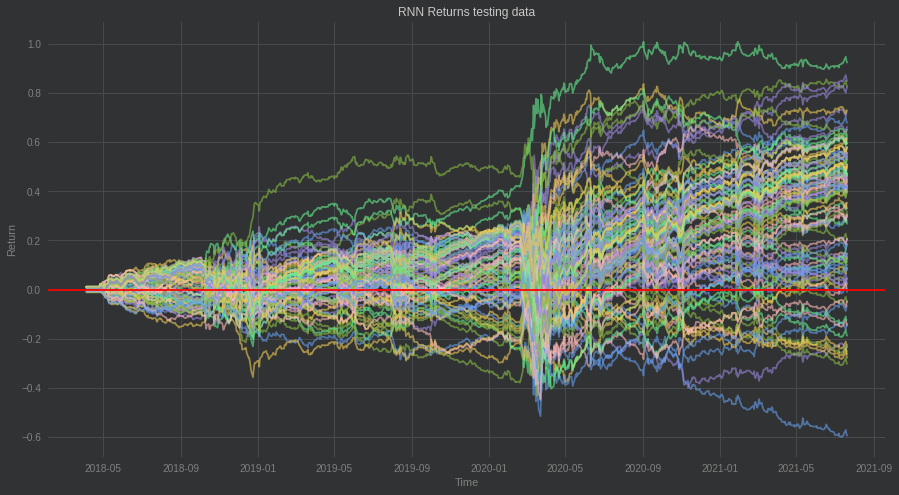

In [ ]:
#Organize well all the data
RNN_returns = pd.DataFrame(returns_val, index=[
    f"RNN_{i}" for i in range(len(returns_test))
]).transpose()

#Graph
plt.figure(figsize=(15,8))
plt.plot(RNN_returns.cumsum(axis=0), alpha=0.6)
plt.axhline(0, color="red")
plt.title("RNN Returns testing data")
plt.ylabel("Return")
plt.xlabel("Time")
plt.show()

Crear un criterio de decisión

In [ ]:
RNN_returns

,RNN_0,RNN_1,RNN_2,RNN_3,RNN_4,RNN_5,RNN_6,RNN_7,RNN_8,RNN_9,...,RNN_90,RNN_91,RNN_92,RNN_93,RNN_94,RNN_95,RNN_96,RNN_97,RNN_98,RNN_99
date,,,,,,,,,,,,,,,,,,,,,
2018-04-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.011566,NaN,NaN,NaN,NaN,0.011566,NaN,0.011566
2018-04-05,0.006863,0.006863,0.006863,0.006863,-0.006863,0.006863,0.006863,0.006863,-0.006863,0.006863,...,0.006863,0.006863,0.000000,-0.006863,0.006863,-0.006863,-0.006863,0.000000,0.006863,0.000000
2018-04-06,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,...,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000
2018-04-09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2018-04-10,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-15,0.003262,0.003262,-0.003262,0.003262,-0.003262,-0.003262,0.003262,-0.003262,-0.003262,-0.003262,...,-0.003262,-0.003262,-0.003262,0.003262,-0.003262,-0.003262,0.003262,0.003262,-0.003262,-0.003262
2021-07-16,0.007539,0.007539,-0.007539,0.007539,-0.007539,-0.007539,0.007539,-0.007539,-0.007539,-0.007539,...,-0.007539,-0.007539,-0.007539,0.007539,-0.007539,-0.007539,0.007539,0.007539,-0.007539,-0.007539
2021-07-19,0.015870,0.015870,-0.015870,0.015870,-0.015870,-0.015870,0.015870,-0.015870,-0.015870,-0.015870,...,-0.015870,-0.015870,-0.015870,0.015870,-0.015870,-0.015870,0.015870,0.015870,-0.015870,-0.015870


We fixed the problem of stochastic initialization with a criteria that filters the best DNNs

In [ ]:
#Create an empty Dataframe
dnns = RNN_returns.columns;

values = pd.DataFrame( index = ["Final_return(%)", "Esperanza(%)"] );

for i in dnns:
   Final_return = RNN_returns[i].cumsum().iloc[-1];
   Esperanza = RNN_returns[i].mean()*100;
   values[i] = Final_return*100, Esperanza*100;

best_models = list(values.transpose().sort_values(by="Esperanza(%)", ascending = False).index[0:9]);
values.transpose().sort_values(by="Esperanza(%)", ascending = False)

,Final_return(%),Esperanza(%)
RNN_1,92.355637,11.127185
RNN_38,84.915733,10.230811
RNN_16,82.654297,9.958349
RNN_20,82.431104,9.931458
RNN_81,NaN,8.799916
...,...,...
RNN_46,-25.234962,-3.040357
RNN_63,-26.258783,-3.163709
RNN_39,-27.684784,-3.335516
RNN_64,-30.223880,-3.641431
